# Multi-Objective Optimization: MOPSO, NTA, and MONLTA

## Overview

This notebook demonstrates and compares **three multi-objective heuristic optimization algorithms** applied to PID controller tuning for a glass melter level control system. The central contribution is the implementation of the **MONLTA** algorithm from the research paper by Nahas, Abouheaf et al. (2021), adapted from power systems to glass manufacturing.

### Methods Implemented

| # | Method | Family | Multi-Objective Strategy |
|---|--------|--------|--------------------------|
| 1 | **Multi-Objective Particle Swarm Optimization (MOPSO)** | Population-based (swarm) | External Pareto archive + crowding distance leader selection |
| 2 | **Nonlinear Threshold Accepting (NTA)** | Local search (SA-family) | Weighted-sum scalarization with multiple weight vectors |
| 3 | **Multi-Objective Nonlinear Threshold Accepting (MONLTA)** | Local search (SA-family) | True Pareto-based with 4 acceptance scenarios (paper's approach) |

### Application: PID Controller Tuning for Glass Melter Level Control

The **decision variables** are the PID gains $(K_p, K_i, K_d)$, and the **objectives** (all minimized simultaneously) are:
- $f_1$: **Integral Absolute Error (IAE)** — measures cumulative tracking error
- $f_2$: **Overshoot (%)** — measures how far the response exceeds the setpoint
- $f_3$: **Settling Time (h)** — measures how quickly the system reaches steady state

**Additional performance metrics** computed (following the paper's approach):
- ISE (Integral Squared Error), ITSE (Integral Time-weighted Squared Error), ITAE (Integral Time-weighted Absolute Error)  
- Rise time $\tau_r$, peak time $\tau_p$, 2%- and 5%-band settling times

### Key References
1. Nahas, Abouheaf, Darghouth, Sharaf, "A multi-objective AVR-LFC optimization scheme for multi-area power systems," *Electric Power Systems Research*, 200, 107467 (2021).
2. Coello et al., "Handling Multiple Objectives with Particle Swarm Optimization," *IEEE TEVC*, 2004.

---

### Dependencies

The following libraries are required:
- **NumPy** — numerical computations, random number generation, array operations
- **Matplotlib** — publication-quality plotting (2D Pareto fronts, 3D surfaces, convergence curves)
- **SciPy** — ODE integration (`odeint`) for dynamics simulation
- **dataclasses** — clean parameter structs for the glass melter model
- **time / copy** — wall-clock benchmarking and deep-copying of archive solutions

In [1]:
# ============================================================
# IMPORTS AND SETUP
# ============================================================

# Core scientific computing
import numpy as np                          # Array operations, linear algebra, random sampling
import matplotlib.pyplot as plt             # 2D/3D plotting
import matplotlib as mpl                    # Low-level plot configuration
from scipy.integrate import odeint          # ODE solver for dynamics (available for future use)

# Data structures and utilities
from dataclasses import dataclass           # Clean parameter containers
from typing import List, Tuple, Callable, Optional  # Type hints for readability
import time                                 # Wall-clock timing of optimization runs
from copy import deepcopy                   # Deep-copy particle personal bests (MOPSO)

# Suppress integration/convergence warnings during optimization sweeps
import warnings
warnings.filterwarnings('ignore')

# ---- Publication-quality plot defaults ----
# Using seaborn whitegrid for clean academic-style figures
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams.update({
    'figure.figsize': (10, 6),    # Default figure size (width, height) in inches
    'figure.dpi': 150,            # Screen resolution for inline display
    'font.size': 11,              # Base font size
    'axes.labelsize': 12,         # Axis label font size
    'axes.titlesize': 13,         # Subplot title font size
    'legend.fontsize': 10,        # Legend font size
    'lines.linewidth': 2.0,       # Default line width
})

# ---- Colorblind-friendly palette (Okabe-Ito) ----
# These colors are distinguishable by ~99% of color-vision-deficient viewers
COLORS = {
    'blue': '#0072B2',      # MOPSO
    'orange': '#D55E00',    # NTA (Weighted-Sum)
    'green': '#009E73',     # MONLTA (Paper)
    'purple': '#CC79A7',    # Accent / secondary axis
    'cyan': '#56B4E9',      # Accent / convergence curves
}

print("✅ Imports complete")
print(f"NumPy version: {np.__version__}")

✅ Imports complete
NumPy version: 2.3.4


## 1. Problem Definition: Glass Melter Level Control

### Physical System

A **glass melting furnace** continuously melts raw batch material and delivers molten glass to forming operations. The **glass level** $h(t)$ in the melter must be tightly controlled:
- **Too low** → air entrainment, poor glass quality
- **Too high** → overflow risk, safety hazard

The level is controlled by adjusting the **batch charging rate** $u(t)$ (tons/hour of raw material fed in), while the **production pull** $q_p(t)$ (volume of glass drawn out) acts as a measurable disturbance.

### Simplified Dynamics Model

We use a second-order model for the glass level dynamics:

$$\frac{dh}{dt} = v, \quad \frac{dv}{dt} = -\frac{1}{\tau_m}v + \frac{K_m}{\tau_m}(u - q_p)$$

| Symbol | Description | Typical Value |
|--------|-------------|---------------|
| $h(t)$ | Glass level (m) | ~0.9 m |
| $v(t)$ | Level rate of change (m/h) | ~0 at steady state |
| $u(t)$ | Batch charging control input (t/h) | 0–50 t/h |
| $q_p(t)$ | Production pull disturbance (m³/h) | ~5 m³/h nominal |
| $\tau_m$ | Melting time constant (h) | 2.0 h |
| $K_m$ | Melting gain (m³/t) | 0.15 |

### PID Controller

The classic PID control law is:

$$u(t) = K_p e(t) + K_i \int_0^t e(\tau)d\tau + K_d \frac{de(t)}{dt}$$

where $e(t) = h_{\text{setpoint}} - h(t)$ is the tracking error. The controller includes **anti-windup** to prevent integral saturation when the actuator is at its limits.

In [2]:
# ============================================================
# GLASS MELTER DYNAMICS MODEL & PID CONTROLLER
# ============================================================

@dataclass
class GlassMelterParams:
    """
    Physical parameters for the glass melter level dynamics.
    
    These are representative values for a typical float-glass or
    container-glass melting furnace. The tank cross-sectional area
    A_tank is included for potential extensions (e.g., volume-to-level
    conversion) but the current simplified model works in level units.
    """
    tau_m: float = 2.0      # Melting time constant (hours) — governs how quickly
                             #   the level responds to input changes
    K_m: float = 0.15       # Melting gain (m³/t) — conversion from batch tonnage
                             #   to molten glass volume
    A_tank: float = 50.0    # Tank cross-sectional area (m²) — for volume↔level    
    h_setpoint: float = 0.9 # Level setpoint (m) — desired operating point
    q_p_nom: float = 5.0    # Nominal production pull (m³/h) — steady-state draw rate

# Instantiate with default values
params = GlassMelterParams()


def glass_melter_dynamics(state, t, u_func, q_p_func, params):
    """
    Right-hand side of the glass melter ODE system.
    
    This implements the second-order level dynamics:
        dh/dt = v                                      (kinematic)
        dv/dt = (-v + K_m*(u - q_p)) / tau_m           (force balance)
    
    The system resembles a first-order plant with an integrator:
    when u = q_p, the level velocity v exponentially decays to zero
    with time constant tau_m, and the level h settles at its current value.
    
    Args:
        state: [h, v] — current level and its rate of change
        t: current time (hours)
        u_func: callable(t) → batch charging rate (t/h)
        q_p_func: callable(t) → production pull disturbance (m³/h)
        params: GlassMelterParams instance
    
    Returns:
        [dh_dt, dv_dt]
    """
    h, v = state
    u = u_func(t)       # Control input at time t
    q_p = q_p_func(t)   # Disturbance at time t
    
    # State equations
    dh_dt = v                                            # Level changes at rate v
    dv_dt = (-v + params.K_m * (u - q_p)) / params.tau_m  # Damped response to net input
    
    return [dh_dt, dv_dt]


class PIDController:
    """
    Discrete-time PID Controller with anti-windup protection.
    
    The controller computes: u = Kp*e + Ki*∫e dt + Kd*de/dt
    
    Anti-windup mechanism:
        When the output saturates (hits u_min or u_max), the integral
        term is back-calculated to prevent "windup" — a condition where
        the integral accumulates large values during saturation, causing
        sluggish recovery and excessive overshoot when the error changes sign.
    """
    
    def __init__(self, Kp, Ki, Kd, u_min=0, u_max=50, dt=0.01):
        """
        Args:
            Kp: Proportional gain — immediate response to error magnitude
            Ki: Integral gain — eliminates steady-state error over time
            Kd: Derivative gain — anticipates future error, provides damping
            u_min: Lower actuator limit (t/h) — cannot have negative batch feed
            u_max: Upper actuator limit (t/h) — physical feeder capacity
            dt: Time step (h) — must match simulation step size
        """
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.u_min = u_min
        self.u_max = u_max
        self.dt = dt
        self.reset()
    
    def reset(self):
        """Reset integrator and derivative memory — call before each new simulation."""
        self.integral = 0.0
        self.prev_error = 0.0
    
    def compute(self, error):
        """
        Compute one step of the PID controller.
        
        Args:
            error: e(t) = setpoint - measurement  (positive means "below setpoint")
        
        Returns:
            u_sat: saturated control output (clipped to [u_min, u_max])
        """
        # --- Proportional term: P = Kp * e(t) ---
        # Provides immediate corrective action proportional to the current error.
        P = self.Kp * error
        
        # --- Integral term: I = Ki * ∫e(τ)dτ  (trapezoidal approximation) ---
        # Accumulates past errors to drive steady-state error to zero.
        self.integral += error * self.dt
        I = self.Ki * self.integral
        
        # --- Derivative term: D = Kd * de/dt  (backward difference) ---
        # Provides damping by reacting to the rate of change of error.
        # Helps reduce overshoot and oscillations.
        derivative = (error - self.prev_error) / self.dt
        D = self.Kd * derivative
        self.prev_error = error
        
        # --- Total control output (before saturation) ---
        u = P + I + D
        
        # --- Actuator saturation ---
        u_sat = np.clip(u, self.u_min, self.u_max)
        
        # --- Anti-windup: back-calculation method ---
        # If the output was clipped, we subtract the excess from the integral
        # to prevent wind-up. This is the most common industrial anti-windup scheme.
        if u != u_sat:
            self.integral -= (u - u_sat) / self.Ki if self.Ki > 0 else 0
        
        return u_sat

print("✅ Glass melter model and PID controller defined")

✅ Glass melter model and PID controller defined


### Closed-Loop Simulation & Performance Metrics

The simulation runs a **20-hour closed-loop test** with:
- **Phase 1** (0–10 h): Level starts at $h_0 = 0.85$ m, controller drives it to setpoint $h_{\text{sp}} = 0.9$ m (step tracking)
- **Phase 2** (10–20 h): A **+20% step disturbance** in production pull tests disturbance rejection

#### Performance Metrics (following Nahas et al. 2021)

The paper evaluates controllers using multiple integral error criteria, each emphasizing different aspects of the response:

| Metric | Formula | Emphasis |
|--------|---------|----------|
| **IAE** | $\int_0^\infty \|e(t)\| \, dt$ | Total cumulative error magnitude |
| **ISE** | $\int_0^\infty e^2(t) \, dt$ | Penalizes large errors more heavily |
| **ITSE** | $\int_0^\infty t \cdot e^2(t) \, dt$ | Penalizes large **late** errors (rewards quick settling) |
| **ITAE** | $\int_0^\infty t \cdot \|e(t)\| \, dt$ | Penalizes persistent errors at later times |

Additionally, **time-domain specifications** are computed:
- **Overshoot** $M_p$ (%): maximum response exceedance beyond setpoint
- **Settling time** $\tau_s$: time for response to stay within ±2% (or ±5%) of setpoint
- **Rise time** $\tau_r$: time from 10% to 90% of the step change
- **Peak time** $\tau_p$: time to first peak

> **Why multiple metrics?** As Nahas et al. note, each single metric has drawbacks — IAE/ISE can produce small overshoot but long settling times; ITAE/ITSE can lead to multiple optima with the same cost. Using them together in a multi-objective framework avoids these pitfalls.

In [3]:
# ============================================================
# CLOSED-LOOP SIMULATION FUNCTION
# ============================================================
# This function is the "inner loop" called thousands of times by 
# each optimizer. It simulates the PID-controlled glass melter
# for a given set of gains and returns all performance metrics.
# ============================================================

def simulate_closed_loop(Kp, Ki, Kd, params, T_sim=20.0, dt=0.01, 
                         h0=0.85, setpoint=0.9, disturbance_time=10.0):
    """
    Simulate PID-controlled glass melter in closed loop.
    
    The simulation has two phases:
      Phase 1 (0 to disturbance_time): step tracking from h0 to setpoint
      Phase 2 (disturbance_time to T_sim): +20% production pull disturbance
    
    Args:
        Kp, Ki, Kd: PID controller gains (decision variables for optimization)
        params: GlassMelterParams — plant model parameters
        T_sim: Total simulation time (hours)
        dt: Integration time step (hours) — Euler method
        h0: Initial glass level (m)
        setpoint: Desired glass level (m)
        disturbance_time: When the production pull step disturbance occurs (h)
    
    Returns:
        t: time array (n_steps,)
        h: glass level trajectory (n_steps,)
        u: control input trajectory (n_steps,)
        metrics: dict with all performance metrics (IAE, ISE, ITSE, ITAE,
                 overshoot, settling times, rise time, peak time)
    """
    n_steps = int(T_sim / dt)
    t = np.linspace(0, T_sim, n_steps)
    
    # Pre-allocate state trajectories
    h = np.zeros(n_steps)   # Glass level (m)
    v = np.zeros(n_steps)   # Level rate of change (m/h)
    u = np.zeros(n_steps)   # Control input (t/h)
    h[0] = h0               # Initial condition: below setpoint
    v[0] = 0.0              # Starting from rest
    
    # Create PID controller with the given gains
    pid = PIDController(Kp, Ki, Kd, u_min=0, u_max=50, dt=dt)
    
    # Production pull profile — step disturbance at t = disturbance_time
    # This tests the controller's disturbance rejection capability
    def q_p(t_val):
        if t_val >= disturbance_time:
            return params.q_p_nom * 1.2  # +20% step increase in pull rate
        return params.q_p_nom            # Nominal pull rate
    
    # ---- Forward Euler time-stepping loop ----
    # We use explicit Euler for speed (this function is called ~15,000+ times
    # during optimization). For the smooth dynamics here, dt=0.01h is adequate.
    for i in range(1, n_steps):
        # Compute tracking error: positive when level is below setpoint
        error = setpoint - h[i-1]
        
        # PID controller computes the batch charging rate
        u[i] = pid.compute(error)
        
        # Plant dynamics (Euler step)
        q_p_val = q_p(t[i])
        dv = (-v[i-1] + params.K_m * (u[i] - q_p_val)) / params.tau_m
        v[i] = v[i-1] + dv * dt    # Update velocity
        h[i] = h[i-1] + v[i] * dt  # Update level
    
    # ============================================================
    # COMPUTE PERFORMANCE METRICS
    # Following the formulations in Nahas et al. (2021)
    # ============================================================
    
    error_traj = setpoint - h        # Signed error trajectory
    abs_error = np.abs(error_traj)   # Absolute error |e(t)|
    sq_error = error_traj**2         # Squared error e²(t)
    
    # --- Integral error metrics (numerical integration via trapezoidal rule) ---
    
    # IAE: ∫|e(t)|dt — total magnitude of error over time
    # Pro: physically intuitive. Con: treats all times equally
    IAE = np.trapezoid(abs_error, t)
    
    # ISE: ∫e²(t)dt — heavily penalizes large transient errors
    # Pro: differentiable, unique minimum. Con: can allow slow settling
    ISE = np.trapezoid(sq_error, t)
    
    # ITSE: ∫t·e²(t)dt — penalizes large errors at LATE times
    # Pro: rewards fast settling. This is the primary metric in the paper
    ITSE = np.trapezoid(t * sq_error, t)
    
    # ITAE: ∫t·|e(t)|dt — penalizes persistent errors as time grows
    # Pro: more selective than IAE. Con: can have multiple minima
    ITAE = np.trapezoid(t * abs_error, t)
    
    # --- Time-domain specifications ---
    
    # Overshoot Mp (%): how far the peak response exceeds the setpoint
    # Expressed as percentage of the step magnitude (setpoint - h0)
    if h0 < setpoint:
        overshoot = max(0, (np.max(h) - setpoint) / (setpoint - h0) * 100)
    else:
        overshoot = max(0, (setpoint - np.min(h)) / (h0 - setpoint) * 100) if h0 != setpoint else 0.0
    
    # Settling time: last time the response exits the tolerance band
    # We compute both 2% and 5% bands (paper uses 5% for AVR)
    tolerance_2pct = 0.02 * abs(setpoint - h0)  # ±2% of step size = ±0.001 m
    tolerance_5pct = 0.05 * abs(setpoint - h0)  # ±5% of step size = ±0.0025 m
    
    settling_time_2pct = T_sim  # Default: never settles
    settling_time_5pct = T_sim
    
    settled_2 = np.abs(h - setpoint) <= tolerance_2pct
    settled_5 = np.abs(h - setpoint) <= tolerance_5pct
    
    # Search backward from end to find last violation
    for i in range(len(settled_2) - 1, -1, -1):
        if not settled_2[i]:
            settling_time_2pct = t[min(i + 1, len(t) - 1)]
            break
    
    for i in range(len(settled_5) - 1, -1, -1):
        if not settled_5[i]:
            settling_time_5pct = t[min(i + 1, len(t) - 1)]
            break
    
    # Rise time τr: time for response to go from 10% to 90% of final value
    # Measures how "fast" the initial transient is
    target_10 = h0 + 0.1 * (setpoint - h0)  # 10% of step = 0.855 m
    target_90 = h0 + 0.9 * (setpoint - h0)  # 90% of step = 0.895 m
    t_10 = T_sim
    t_90 = T_sim
    for i in range(len(h)):
        if h[i] >= target_10:
            t_10 = t[i]
            break
    for i in range(len(h)):
        if h[i] >= target_90:
            t_90 = t[i]
            break
    rise_time = t_90 - t_10
    
    # Peak time τp: time at which the response reaches its maximum
    peak_idx = np.argmax(h)
    peak_time = t[peak_idx]
    
    # Package all metrics into a dictionary
    metrics = {
        'IAE': IAE,
        'ISE': ISE,
        'ITSE': ITSE,
        'ITAE': ITAE,
        'overshoot': overshoot,
        'settling_time': settling_time_2pct,
        'settling_time_5pct': settling_time_5pct,
        'rise_time': rise_time,
        'peak_time': peak_time,
    }
    
    return t, h, u, metrics


# ---- Quick sanity check with moderate PID gains ----
t, h, u, metrics = simulate_closed_loop(Kp=100, Ki=10, Kd=5, params=params)
print(f"Test simulation with Kp=100, Ki=10, Kd=5:")
print(f"  IAE:  {metrics['IAE']:.4f}")
print(f"  ISE:  {metrics['ISE']:.6f}")
print(f"  ITSE: {metrics['ITSE']:.6f}")
print(f"  ITAE: {metrics['ITAE']:.4f}")
print(f"  Overshoot: {metrics['overshoot']:.2f}%")
print(f"  Settling Time (2%): {metrics['settling_time']:.2f} h")
print(f"  Settling Time (5%): {metrics['settling_time_5pct']:.2f} h")
print(f"  Rise Time: {metrics['rise_time']:.4f} h")
print(f"  Peak Time: {metrics['peak_time']:.4f} h")

Test simulation with Kp=100, Ki=10, Kd=5:
  IAE:  0.4966
  ISE:  0.014393
  ITSE: 0.085340
  ITAE: 3.8788
  Overshoot: 0.00%
  Settling Time (2%): 20.00 h
  Settling Time (5%): 20.00 h
  Rise Time: 19.6498 h
  Peak Time: 20.0000 h


## 2. Multi-Objective Optimization Framework

### Why Multi-Objective?

As Nahas et al. (2021) emphasize, using a **single** performance index has inherent drawbacks:
- **IAE/ISE**: errors are weighted equally regardless of time → can produce small overshoot but **long settling time** (or vice versa)
- **ITAE/ITSE**: time-weighting can lead to **multiple minima** — two very different gain sets may yield the same cost value
- **ITSE** alone cannot guarantee a desired **stability margin**

By treating **multiple criteria simultaneously** in a Pareto-based framework, we avoid these problems and give the designer a set of trade-off solutions to choose from.

### Objective Functions

We define a tri-objective optimization problem:

$$\min_{K_p, K_i, K_d} \mathbf{f}(\mathbf{x}) = \begin{bmatrix} f_1(\mathbf{x}) \\ f_2(\mathbf{x}) \\ f_3(\mathbf{x}) \end{bmatrix} = \begin{bmatrix} \text{IAE} \\ \text{Overshoot (\%)} \\ \text{Settling Time (h)} \end{bmatrix}$$

### Pareto Dominance

A solution $\mathbf{x}_1$ **dominates** $\mathbf{x}_2$ (written $\mathbf{x}_1 \prec \mathbf{x}_2$) if and only if:
1. $f_i(\mathbf{x}_1) \leq f_i(\mathbf{x}_2)$ for **all** objectives $i = 1, \ldots, N$
2. $f_j(\mathbf{x}_1) < f_j(\mathbf{x}_2)$ for **at least one** objective $j$

The set of all non-dominated solutions forms the **Pareto front** — no solution on this front can improve one objective without worsening another.

### Crowding Distance

To maintain diversity on the Pareto front, we use **crowding distance** (Deb et al., 2002): for each solution, measure the average side-length of the cuboid formed by its nearest neighbors in objective space. Solutions in sparse regions get higher crowding distance and are preferred during archive pruning.

In [4]:
# ============================================================
# MULTI-OBJECTIVE OPTIMIZATION UTILITIES
# These functions are shared by all three optimizers (MOPSO, NTA, MONLTA).
# ============================================================

def evaluate_objectives(x, params):
    """
    Evaluate all three objective functions for a candidate PID gain vector.
    
    This is the "fitness function" called by each optimizer. It runs a full
    closed-loop simulation and extracts the three objectives we want to minimize.
    
    Args:
        x: [Kp, Ki, Kd] — candidate PID gains (decision variables)
        params: GlassMelterParams — plant model parameters
    
    Returns:
        [IAE, overshoot, settling_time] — objective vector (all to be minimized)
        Returns [1e6, 1e6, 1e6] for invalid/unstable solutions
    """
    Kp, Ki, Kd = x
    
    # Guard: reject physically meaningless gains
    if Kp <= 0 or Ki < 0 or Kd < 0:
        return [1e6, 1e6, 1e6]  # Penalize invalid solutions
    
    try:
        _, _, _, metrics = simulate_closed_loop(Kp, Ki, Kd, params)
        return [metrics['IAE'], metrics['overshoot'], metrics['settling_time']]
    except:
        return [1e6, 1e6, 1e6]  # Simulation diverged or failed


def dominates(f1, f2):
    """
    Check Pareto dominance: does solution f1 dominate solution f2?
    
    Definition: f1 ≺ f2  iff
        (1) f1_i ≤ f2_i  for ALL objectives i  (at least as good everywhere)
        (2) f1_j < f2_j  for AT LEAST ONE j    (strictly better somewhere)
    
    This is the fundamental operator for all Pareto-based multi-objective
    optimizers. It defines a partial ordering over the objective space.
    
    Args:
        f1, f2: objective vectors (lists of floats)
    
    Returns:
        True if f1 dominates f2, False otherwise
    """
    better_in_all = all(a <= b for a, b in zip(f1, f2))  # Condition (1)
    better_in_one = any(a < b for a, b in zip(f1, f2))   # Condition (2)
    return better_in_all and better_in_one


def get_pareto_front(solutions, objectives):
    """
    Extract the Pareto-optimal (non-dominated) subset from a set of solutions.
    
    Brute-force O(n²) approach: for each solution, check if any other solution
    dominates it. If not, it belongs to the Pareto front.
    
    Args:
        solutions: list of candidate solution vectors (e.g., [Kp, Ki, Kd])
        objectives: list of objective vectors (e.g., [IAE, OS, Ts])
    
    Returns:
        pareto_solutions, pareto_objectives — the non-dominated subset
    """
    n = len(solutions)
    is_pareto = np.ones(n, dtype=bool)
    
    for i in range(n):
        for j in range(n):
            if i != j and dominates(objectives[j], objectives[i]):
                is_pareto[i] = False  # Solution i is dominated by j
                break                 # No need to check further
    
    pareto_solutions = [solutions[i] for i in range(n) if is_pareto[i]]
    pareto_objectives = [objectives[i] for i in range(n) if is_pareto[i]]
    
    return pareto_solutions, pareto_objectives


def crowding_distance(objectives):
    """
    Compute crowding distance for each solution in the objective space.
    
    Crowding distance measures how "isolated" a solution is on the Pareto front.
    Solutions in less-crowded regions get higher distances and are preferred
    during archive pruning, promoting a well-spread Pareto front.
    
    Algorithm (Deb et al., NSGA-II, 2002):
        For each objective m:
            1. Sort solutions by objective m
            2. Boundary solutions get infinite distance (always preserved)
            3. Interior solutions: distance += (neighbor_above - neighbor_below) / range
    
    Args:
        objectives: list of objective vectors
    
    Returns:
        list of crowding distances (one per solution)
    """
    n = len(objectives)
    if n <= 2:
        return [float('inf')] * n  # Boundary solutions always kept
    
    n_obj = len(objectives[0])
    distances = np.zeros(n)
    
    for m in range(n_obj):
        # Sort solutions by objective m
        sorted_idx = np.argsort([obj[m] for obj in objectives])
        
        # Boundary points (best and worst in this objective) get infinite distance
        # This ensures the extremes of the Pareto front are always preserved
        distances[sorted_idx[0]] = float('inf')
        distances[sorted_idx[-1]] = float('inf')
        
        # Range of this objective (for normalization)
        obj_range = objectives[sorted_idx[-1]][m] - objectives[sorted_idx[0]][m]
        if obj_range == 0:
            continue  # All solutions have same value for this objective
        
        # Interior points: normalized Manhattan distance to neighbors
        for i in range(1, n - 1):
            distances[sorted_idx[i]] += (
                objectives[sorted_idx[i+1]][m] - objectives[sorted_idx[i-1]][m]
            ) / obj_range
    
    return distances.tolist()

print("✅ Multi-objective utilities defined (dominance, Pareto extraction, crowding distance)")

✅ Multi-objective utilities defined (dominance, Pareto extraction, crowding distance)


## 3. Multi-Objective Particle Swarm Optimization (MOPSO)

### Algorithm Overview

**MOPSO** (Coello et al., IEEE TEVC 2004) extends standard PSO to handle multiple objectives. In standard PSO, a swarm of particles flies through the search space, each attracted toward its **personal best** (cognitive) and the **global best** (social). For multi-objectives, there is no single "global best" — instead we have a **Pareto archive**.

### Key Components

1. **External Pareto Archive**: Stores all non-dominated solutions found so far. Updated each iteration with dominance checks.

2. **Leader Selection via Crowding Distance**: The global best (leader) for each particle is selected from the archive using roulette-wheel selection weighted by crowding distance — particles in less-crowded regions are more likely to be selected as leaders, promoting exploration of the entire Pareto front.

3. **Polynomial Mutation**: Random perturbations applied with probability `mutation_prob` to maintain diversity and prevent premature convergence.

### Velocity Update Equation

$$v_i^{t+1} = w \cdot v_i^t + c_1 r_1 (p_{\text{best},i} - x_i^t) + c_2 r_2 (g_{\text{best}} - x_i^t)$$

where:
- $w = 0.4$: inertia weight (lower → more exploitation, less exploration)
- $c_1 = 2.0$: cognitive coefficient (attraction to personal best)
- $c_2 = 2.0$: social coefficient (attraction to archive leader)
- $r_1, r_2 \sim U(0,1)$: random vectors for stochasticity
- $g_{\text{best}}$: selected from archive via crowding-distance-weighted roulette wheel

In [5]:
# ============================================================
# MULTI-OBJECTIVE PARTICLE SWARM OPTIMIZATION (MOPSO)
# ============================================================
# Reference: Coello et al., "Handling Multiple Objectives with 
# Particle Swarm Optimization," IEEE TEVC, 2004.
#
# MOPSO is a POPULATION-BASED metaheuristic: it maintains a swarm
# of n_particles candidate solutions that move through the search
# space simultaneously. This provides parallel exploration but 
# requires more function evaluations per iteration than local search.
# ============================================================

class MOPSO:
    """
    Multi-Objective Particle Swarm Optimization.
    
    The swarm evolves over n_iterations, building up a Pareto archive
    of non-dominated solutions. At the end, the archive IS the 
    approximate Pareto front.
    """
    
    def __init__(self, n_particles=50, n_iterations=100, 
                 bounds=None, n_objectives=3, archive_size=100,
                 w=0.4, c1=2.0, c2=2.0, mutation_prob=0.1):
        """
        Args:
            n_particles: Swarm size — more particles = better exploration but slower
            n_iterations: Number of PSO iterations (generations)
            bounds: [(min, max)] for each decision variable dimension
            n_objectives: Number of objectives (3 for our problem: IAE, OS, Ts)
            archive_size: Max Pareto archive capacity — pruned via crowding distance
            w: Inertia weight — controls exploration/exploitation balance.
               w < 1 causes velocities to decay, promoting convergence.
            c1: Cognitive coefficient — how strongly a particle is attracted
                to its own personal best position
            c2: Social coefficient — how strongly a particle is attracted
                to the global best (archive leader)
            mutation_prob: Per-dimension probability of polynomial mutation
        """
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.bounds = bounds
        self.n_dim = len(bounds)
        self.n_objectives = n_objectives
        self.archive_size = archive_size
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.mutation_prob = mutation_prob
        
        # External archive: stores the best non-dominated solutions found
        self.archive_solutions = []
        self.archive_objectives = []
        
        # History for convergence analysis
        self.history = []
    
    def initialize(self):
        """
        Initialize particle positions and velocities.
        
        Positions are uniformly random within bounds.
        Velocities are initialized small (10% of range) to prevent
        particles from immediately flying out of bounds.
        """
        self.positions = np.zeros((self.n_particles, self.n_dim))
        self.velocities = np.zeros((self.n_particles, self.n_dim))
        
        for d in range(self.n_dim):
            low, high = self.bounds[d]
            self.positions[:, d] = np.random.uniform(low, high, self.n_particles)
            vel_range = (high - low) * 0.1  # Initial velocity: ±10% of range
            self.velocities[:, d] = np.random.uniform(-vel_range, vel_range, self.n_particles)
        
        # Personal best: each particle remembers its best-ever position
        self.pbest_positions = self.positions.copy()
        self.pbest_objectives = [None] * self.n_particles
    
    def update_archive(self, solutions, objectives):
        """
        Update the external Pareto archive with new candidate solutions.
        
        For each new solution:
          1. Check if it's dominated by any existing archive member → skip
          2. Remove any archive members it dominates
          3. If archive exceeds capacity → prune using crowding distance
             (remove the most crowded solutions to maintain spread)
        """
        for sol, obj in zip(solutions, objectives):
            if obj[0] >= 1e5:  # Skip invalid/failed solutions
                continue
            
            is_dominated = False
            to_remove = []
            
            for i, arch_obj in enumerate(self.archive_objectives):
                if dominates(arch_obj, obj):
                    is_dominated = True   # New solution is inferior → discard
                    break
                if dominates(obj, arch_obj):
                    to_remove.append(i)   # New solution beats archive member → remove old
            
            if not is_dominated:
                # Remove archive members that the new solution dominates
                for i in sorted(to_remove, reverse=True):
                    del self.archive_solutions[i]
                    del self.archive_objectives[i]
                
                # Add the new non-dominated solution
                self.archive_solutions.append(sol.copy())
                self.archive_objectives.append(obj.copy())
        
        # Prune archive if it exceeds capacity
        # Strategy: keep the solutions with highest crowding distance (most diverse)
        if len(self.archive_solutions) > self.archive_size:
            distances = crowding_distance(self.archive_objectives)
            sorted_idx = np.argsort(distances)[::-1]  # Descending: most isolated first
            self.archive_solutions = [self.archive_solutions[i] for i in sorted_idx[:self.archive_size]]
            self.archive_objectives = [self.archive_objectives[i] for i in sorted_idx[:self.archive_size]]
    
    def select_leader(self):
        """
        Select a global best (leader) from the archive for social attraction.
        
        Uses roulette-wheel selection weighted by crowding distance:
        solutions in sparser regions are more likely to be selected,
        which guides the swarm toward under-explored areas of the Pareto front.
        """
        if len(self.archive_solutions) == 0:
            return None
        
        distances = crowding_distance(self.archive_objectives)
        
        # Build probability distribution: higher crowding distance → higher probability
        total = sum(d for d in distances if d != float('inf'))
        if total == 0:
            # All solutions have infinite distance (≤2 solutions) → random choice
            return self.archive_solutions[np.random.randint(len(self.archive_solutions))]
        
        probs = [d / total if d != float('inf') else 1.0 for d in distances]
        probs = np.array(probs) / sum(probs)  # Normalize to valid distribution
        idx = np.random.choice(len(self.archive_solutions), p=probs)
        return self.archive_solutions[idx]
    
    def mutate(self, position):
        """
        Apply polynomial mutation to maintain diversity.
        
        With probability mutation_prob, each dimension is perturbed by
        a Gaussian noise scaled to 10% of the dimension's range.
        This prevents the swarm from collapsing to a single point.
        """
        mutated = position.copy()
        for d in range(self.n_dim):
            if np.random.random() < self.mutation_prob:
                low, high = self.bounds[d]
                delta = (high - low) * 0.1 * np.random.randn()
                mutated[d] = np.clip(mutated[d] + delta, low, high)
        return mutated
    
    def optimize(self, objective_func, verbose=True):
        """
        Run the MOPSO optimization loop.
        
        Main loop structure:
            For each iteration:
                For each particle:
                    1. Select leader from archive (crowding-distance roulette)
                    2. Update velocity: v = w*v + c1*r1*(pbest-x) + c2*r2*(leader-x)
                    3. Update position: x = x + v
                    4. Clip to bounds
                    5. Apply mutation
                    6. Evaluate objectives
                    7. Update personal best (dominance-based)
                Update archive with all new solutions
        
        Args:
            objective_func: callable(x) → [f1, f2, f3]
            verbose: print progress every 10 iterations
        
        Returns:
            pareto_solutions, pareto_objectives (the final archive)
        """
        start_time = time.time()
        self.initialize()
        
        # ----- Evaluate initial swarm -----
        objectives = [objective_func(self.positions[i]) for i in range(self.n_particles)]
        self.pbest_objectives = deepcopy(objectives)
        
        # Seed the archive with initial non-dominated solutions
        self.update_archive(self.positions, objectives)
        
        if verbose:
            print(f"MOPSO Optimization Started")
            print(f"  Particles: {self.n_particles}, Iterations: {self.n_iterations}")
            print(f"  Total evaluations budget: {self.n_particles * self.n_iterations}")
            print("-" * 60)
        
        # ----- Main PSO loop -----
        for iteration in range(self.n_iterations):
            for i in range(self.n_particles):
                # Step 1: Select leader from archive
                gbest = self.select_leader()
                if gbest is None:
                    gbest = self.positions[i]  # Fallback: use own position
                
                # Step 2: Update velocity (PSO canonical equation)
                r1 = np.random.random(self.n_dim)  # Random cognitive factors
                r2 = np.random.random(self.n_dim)   # Random social factors
                cognitive = self.c1 * r1 * (self.pbest_positions[i] - self.positions[i])
                social = self.c2 * r2 * (gbest - self.positions[i])
                self.velocities[i] = self.w * self.velocities[i] + cognitive + social
                
                # Step 3: Update position
                self.positions[i] += self.velocities[i]
                
                # Step 4: Enforce bounds (absorbing boundary)
                for d in range(self.n_dim):
                    low, high = self.bounds[d]
                    self.positions[i, d] = np.clip(self.positions[i, d], low, high)
                
                # Step 5: Apply mutation for diversity
                self.positions[i] = self.mutate(self.positions[i])
                
                # Step 6: Evaluate objectives at new position
                new_obj = objective_func(self.positions[i])
                objectives[i] = new_obj
                
                # Step 7: Update personal best using dominance
                if dominates(new_obj, self.pbest_objectives[i]):
                    # New position dominates old personal best → update
                    self.pbest_positions[i] = self.positions[i].copy()
                    self.pbest_objectives[i] = new_obj.copy()
                elif not dominates(self.pbest_objectives[i], new_obj):
                    # Neither dominates → randomly choose (tie-breaking)
                    if np.random.random() < 0.5:
                        self.pbest_positions[i] = self.positions[i].copy()
                        self.pbest_objectives[i] = new_obj.copy()
            
            # Update archive with all particles from this iteration
            self.update_archive(self.positions, objectives)
            
            # Record convergence history
            self.history.append({
                'iteration': iteration,
                'archive_size': len(self.archive_solutions),
                'best_IAE': min(obj[0] for obj in self.archive_objectives) if self.archive_objectives else float('inf')
            })
            
            if verbose and (iteration + 1) % 10 == 0:
                print(f"  Iteration {iteration+1:3d}: Archive size = {len(self.archive_solutions):3d}, "
                      f"Best IAE = {self.history[-1]['best_IAE']:.4f}")
        
        elapsed = time.time() - start_time
        if verbose:
            print("-" * 60)
            print(f"Optimization complete in {elapsed:.2f}s")
            print(f"Final Pareto front size: {len(self.archive_solutions)}")
        
        return self.archive_solutions, self.archive_objectives

print("✅ MOPSO class defined")

✅ MOPSO class defined


## 4. Multi-Objective Nonlinear Threshold Accepting (MONLTA)

Based on: **Nahas, Abouheaf, Darghouth, Sharaf, "A multi-objective AVR-LFC optimization scheme for multi-area power systems," *Electric Power Systems Research*, 200, 107467 (2021).**

### Background: From Simulated Annealing to MONLTA

**Threshold Accepting (TA)** is a variant of Simulated Annealing that simplifies the Boltzmann acceptance criterion — instead of a probabilistic acceptance via $e^{-\Delta/T}$, TA accepts a worse solution whenever the degradation $\Delta$ is below a deterministic threshold $T_k$. This eliminates the noise of random acceptance and makes convergence more predictable.

**Nonlinear TA (NLTA)** replaces the linear threshold schedule with a nonlinear one. The paper introduces a novel **low-pass filter transfer function** form:

$$H(\zeta) = \frac{1}{\sqrt{1 + (\zeta / \zeta_0)^2}}$$

This function transitions smoothly from $H \approx 1$ (accept almost anything) when $\zeta$ is small to $H \approx 0$ (only accept improvements) when $\zeta$ is large. The parameter $\zeta$ starts high and decreases linearly each iteration ($\zeta \leftarrow \zeta - \Delta\zeta$), so the threshold tightens over time — analogous to "cooling" in SA.

### What Makes MONLTA Different from Weighted-Sum NTA?

| Feature | NTA (Weighted-Sum) | MONLTA (Paper) |
|---------|-------------------|----------------|
| Multi-objective handling | Scalarize via $\sum w_i f_i$ | True Pareto dominance |
| Weight assignment | Required (arbitrary) | Not needed |
| Acceptance criterion | $\Delta f < T_k$ (scalar) | 4 dominance-based scenarios |
| Solution quality | Depends on weight choice | Entire Pareto front |
| Concavity handling | May miss concave regions | Handles arbitrary front shapes |

### The Four Acceptance Scenarios

The algorithm evaluates each neighbor against the current solution and the archive:

1. **Scenario 1**: Neighbor dominates current AND not dominated by archive → **Always accept** (clear improvement)

2. **Scenario 2**: Neighbor dominates current BUT dominated by $k$ archive members → **Always accept** (locally better, globally known-inferior but keeps search moving)

3. **Scenario 3**: Neighbor does NOT dominate current AND dominated by $k$ archive members → **Accept conditionally** using the amount-of-domination average:
$$\frac{O_i^{Av}(X)}{O_i(X)} \leq H(\zeta) \quad \forall i, \quad \text{where } O_i^{Av}(X) = \frac{O_i(X') - \sum_{j=1}^{k} O_i(X_j)}{k+1}$$

4. **Scenario 4**: Neighbor does NOT dominate current AND NOT dominated by archive → **Accept conditionally** if objective ratios are within the threshold:
$$\frac{O_i(X')}{O_i(X)} \leq 1 + H(\zeta) \quad \forall i$$

### Paper's Search Parameters (Used Here)
| Parameter | Value | Meaning |
|-----------|-------|---------|
| $1/\zeta_0$ | 0.0075 | Controls threshold steepness ($\zeta_0 \approx 133.33$) |
| $\zeta_{\text{start}}$ | 40 | Initial frequency (high → start lenient) |
| $\Delta\zeta$ | $\zeta_{\text{start}} / NI$ | Linear decrease per iteration |
| $L$ | 5 | Initial archive size |
| Perturbation | One variable at a time | Focused neighborhood search |

In [10]:
# ============================================================
# MULTI-OBJECTIVE NONLINEAR THRESHOLD ACCEPTING (MONLTA)
# Based on: Nahas et al., Electric Power Systems Research (2021)
# ============================================================

class MONLTA:
    """
    Multi-Objective Nonlinear Threshold Accepting (MONLTA).
    
    A true Pareto-based multi-objective local search that uses a nonlinear 
    accepting function (low-pass filter form) with four acceptance scenarios 
    based on dominance and an amount-of-domination principle.
    
    Unlike MOPSO (population-based), MONLTA is a LOCAL SEARCH: it maintains
    a single current solution that is iteratively perturbed. Multiple independent
    "episodes" are run to explore different regions of the search space, and all
    episodes share a single global Pareto archive.
    
    Key innovation over standard Threshold Accepting:
    - No weight factors → true Pareto-based
    - Amount-of-domination principle → nuanced acceptance of "slightly worse" solutions
    - Low-pass filter threshold → smoother exploration-to-exploitation transition
    
    Reference: Nahas, Abouheaf, Darghouth, Sharaf, "A multi-objective 
    AVR-LFC optimization scheme for multi-area power systems," 
    Electric Power Systems Research, 200, 107467 (2021).
    """
    
    def __init__(self, n_iterations=1000, bounds=None, n_objectives=3,
                 zeta_0_inv=0.0075, zeta_start=40.0, archive_init_size=5,
                 archive_max_size=100, n_episodes=10, perturbation_mode='single'):
        """
        Args:
            n_iterations: Number of iterations per episode (NI in paper)
        """
        self.n_iterations = n_iterations      # NI in paper: iterations per episode
        self.bounds = bounds                      # Decision variable bounds
        self.n_dim = len(bounds)                  # Number of decision variables (3 for PID)
        self.n_objectives = n_objectives          # Number of objectives (3: IAE, OS, Ts)
        self.zeta_0_inv = zeta_0_inv              # 1/ζ₀ = 0.0075 (paper's value)
        self.zeta_0 = 1.0 / zeta_0_inv           # ζ₀ ≈ 133.33 — at this frequency, H = 1/√2 ≈ 0.707
        self.zeta_start = zeta_start              # Starting ζ = 40 → H(40) ≈ 0.958 (lenient start)
        self.delta_zeta = zeta_start / n_iterations  # Δζ = ζ/NI — linear decrease per iteration
        self.archive_init_size = archive_init_size   # L = 5 in paper — initial random archive seeds
        self.archive_max_size = archive_max_size     # Hard cap on archive storage
        self.n_episodes = n_episodes              # Independent search restarts (paper: 10-20)
        self.perturbation_mode = perturbation_mode  # 'single' = paper's one-variable-at-a-time
        self.n_dim = len(bounds)
        # Variable-size Pareto archive (shared across all episodes)
        # This grows as non-dominated solutions are discovered
        self.archive_solutions = []
        self.archive_objectives = []
        
        # Tracking for convergence analysis
        self.history = []
        self.episode_history = []
    
    def H(self, zeta):
        """
        Nonlinear accepting function (low-pass filter transfer function).
        H(ζ) = 1 / sqrt(1 + (ζ/ζ₀)²)
        
        As ζ decreases toward 0, H → 1 (accept easily).
        As ζ is large, H → 0 (only accept improvements).
        """
        return 1.0 / np.sqrt(1.0 + (zeta / self.zeta_0) ** 2)
    
    def generate_neighbor(self, x):
        """
        Generate a neighbor solution.
        
        Paper's approach: randomly select ONE decision variable and assign
        a new random value from its feasible range.
        """
        x_new = x.copy()
        
        if self.perturbation_mode == 'single':
            # Paper's approach: perturb ONE variable at a time
            d = np.random.randint(self.n_dim)
            low, high = self.bounds[d]
            x_new[d] = np.random.uniform(low, high)
        else:
            # Perturb all variables with Gaussian noise
            for d in range(self.n_dim):
                low, high = self.bounds[d]
                delta = (high - low) * 0.1 * np.random.randn()
                x_new[d] = np.clip(x_new[d] + delta, low, high)
        
        return x_new
    
    def find_dominating_archive_members(self, obj):
        """
        Find archive members that dominate the given objective vector.
        Returns indices and count k.
        """
        dominating_indices = []
        for i, arch_obj in enumerate(self.archive_objectives):
            if dominates(arch_obj, obj):
                dominating_indices.append(i)
        return dominating_indices
    
    def amount_of_domination_avg(self, obj_neighbor, dominating_indices):
        """
        Compute amount-of-domination average for each objective.
        
        O_i^Av(X) = [O_i(X') - Σ O_i(X_j)] / (k+1)   for all i
        
        This measures how "badly" the neighbor is dominated relative to
        the archive members that dominate it.
        """
        k = len(dominating_indices)
        if k == 0:
            return obj_neighbor  # No dominating members
        
        avg = []
        for i in range(self.n_objectives):
            sum_dom = sum(self.archive_objectives[j][i] for j in dominating_indices)
            o_av = (obj_neighbor[i] - sum_dom) / (k + 1)
            avg.append(o_av)
        return avg
    
    def update_archive(self, solution, objectives):
        """
        Update the variable-size archive with dominance rules.
        Add non-dominated solutions and remove dominated ones.
        """
        if objectives[0] >= 1e5:
            return
        
        is_dominated = False
        to_remove = []
        
        for i, arch_obj in enumerate(self.archive_objectives):
            if dominates(arch_obj, objectives):
                is_dominated = True
                break
            if dominates(objectives, arch_obj):
                to_remove.append(i)
        
        if not is_dominated:
            for i in sorted(to_remove, reverse=True):
                del self.archive_solutions[i]
                del self.archive_objectives[i]
            
            self.archive_solutions.append(solution.copy())
            self.archive_objectives.append(objectives.copy())
        
        # Prune if exceeding max size using crowding distance
        if len(self.archive_solutions) > self.archive_max_size:
            distances = crowding_distance(self.archive_objectives)
            sorted_idx = np.argsort(distances)[::-1]
            self.archive_solutions = [self.archive_solutions[i] 
                                      for i in sorted_idx[:self.archive_max_size]]
            self.archive_objectives = [self.archive_objectives[i] 
                                       for i in sorted_idx[:self.archive_max_size]]
    
    def acceptance_check(self, x_current, obj_current, x_neighbor, obj_neighbor, zeta):
        """
        Implement the four acceptance scenarios from the paper.
        
        Returns:
            accept: bool — whether to accept the neighbor
            scenario: int — which scenario was triggered (1-4)
        """
        neighbor_dominates_current = dominates(obj_neighbor, obj_current)
        dominating_indices = self.find_dominating_archive_members(obj_neighbor)
        k = len(dominating_indices)
        
        H_zeta = self.H(zeta)
        
        # Scenario 1: Neighbor dominates current AND no archive members dominate neighbor
        if neighbor_dominates_current and k == 0:
            return True, 1
        
        # Scenario 2: Neighbor dominates current BUT k archive members dominate neighbor
        elif neighbor_dominates_current and k > 0:
            return True, 2
        
        # Scenario 3: Neighbor does NOT dominate current AND k archive members dominate neighbor
        elif not neighbor_dominates_current and k > 0:
            # Accept only if amount-of-domination ratio ≤ H(ζ) for ALL objectives
            o_avg = self.amount_of_domination_avg(obj_neighbor, dominating_indices)
            accept = True
            for i in range(self.n_objectives):
                if obj_current[i] > 0:  # Avoid division by zero
                    ratio = abs(o_avg[i]) / abs(obj_current[i])
                    if ratio > H_zeta:
                        accept = False
                        break
                elif o_avg[i] > 0:
                    accept = False
                    break
            return accept, 3
        
        # Scenario 4: Neighbor does NOT dominate current AND no archive members dominate neighbor
        else:  # not neighbor_dominates_current and k == 0
            # Accept only if objective ratio ≤ H(ζ) for ALL objectives
            accept = True
            for i in range(self.n_objectives):
                if obj_current[i] > 0:
                    ratio = obj_neighbor[i] / obj_current[i]
                    if ratio > (1.0 + H_zeta):  # Allow slight worsening proportional to H
                        accept = False
                        break
                elif obj_neighbor[i] > 0:
                    accept = False
                    break
            return accept, 4
    
    def optimize(self, objective_func, verbose=True):
        """
        Run MONLTA optimization over multiple episodes.
        
        Each episode explores the search space with the threshold
        progressively tightening (ζ decreasing → H decreasing → 
        harder to accept worse solutions).
        
        Args:
            objective_func: Function mapping solution vector → objectives list
            verbose: Print progress
        
        Returns:
            pareto_solutions, pareto_objectives
        """
        start_time = time.time()
        total_evals = 0
        scenario_counts = {1: 0, 2: 0, 3: 0, 4: 0}
        accepted_counts = {1: 0, 2: 0, 3: 0, 4: 0}
        
        if verbose:
            print(f"MONLTA Optimization Started (Nahas et al. 2021)")
            print(f"  Episodes: {self.n_episodes}, Iterations/episode: {self.n_iterations}")
            print(f"  ζ₀ = {self.zeta_0:.2f}, ζ_start = {self.zeta_start}, Δζ = {self.delta_zeta:.6f}")
            print(f"  H(ζ_start) = {self.H(self.zeta_start):.4f}, H(Δζ) = {self.H(self.delta_zeta):.4f}")
            print(f"  Perturbation mode: {self.perturbation_mode}")
            print("-" * 65)
        
        for episode in range(self.n_episodes):
            # Initialize with random solution
            x_current = np.array([np.random.uniform(low, high) 
                                  for low, high in self.bounds])
            obj_current = objective_func(x_current)
            total_evals += 1
            
            self.update_archive(x_current, obj_current)
            
            # Initialize archive with L random solutions if first episode
            if episode == 0 and len(self.archive_solutions) < self.archive_init_size:
                for _ in range(self.archive_init_size - len(self.archive_solutions)):
                    x_init = np.array([np.random.uniform(low, high) 
                                       for low, high in self.bounds])
                    obj_init = objective_func(x_init)
                    total_evals += 1
                    self.update_archive(x_init, obj_init)
            
            # Start with full frequency (ζ = ζ_start)
            zeta = self.zeta_start
            episode_accepts = 0
            
            for k in range(self.n_iterations):
                # Generate neighbor
                x_neighbor = self.generate_neighbor(x_current)
                obj_neighbor = objective_func(x_neighbor)
                total_evals += 1
                
                # Check acceptance using four scenarios
                accept, scenario = self.acceptance_check(
                    x_current, obj_current, x_neighbor, obj_neighbor, zeta
                )
                
                scenario_counts[scenario] += 1
                
                if accept:
                    x_current = x_neighbor
                    obj_current = obj_neighbor
                    episode_accepts += 1
                    accepted_counts[scenario] += 1
                    
                    # Update archive with accepted solution
                    self.update_archive(x_current, obj_current)
                
                # Decrease ζ (tighten threshold — analogous to cooling)
                zeta = max(zeta - self.delta_zeta, self.delta_zeta)
            
            # Record episode history
            self.episode_history.append({
                'episode': episode,
                'archive_size': len(self.archive_solutions),
                'accepts': episode_accepts,
                'accept_rate': episode_accepts / self.n_iterations,
                'best_obj': [min(obj[i] for obj in self.archive_objectives) 
                             for i in range(self.n_objectives)] if self.archive_objectives else None
            })
            
            if verbose:
                best = self.episode_history[-1]['best_obj']
                best_str = ", ".join(f"{b:.4f}" for b in best) if best else "N/A"
                print(f"  Episode {episode+1:2d}/{self.n_episodes}: "
                      f"Archive = {len(self.archive_solutions):3d}, "
                      f"Accept rate = {episode_accepts/self.n_iterations:.1%}, "
                      f"Best = [{best_str}]")
        
        elapsed = time.time() - start_time
        
        if verbose:
            print("-" * 65)
            print(f"Optimization complete in {elapsed:.2f}s")
            print(f"Total function evaluations: {total_evals}")
            print(f"Final Pareto front size: {len(self.archive_solutions)}")
            print(f"\nScenario statistics (triggered / accepted):")
            for s in range(1, 5):
                print(f"  Scenario {s}: {scenario_counts[s]:5d} / {accepted_counts[s]:5d}")
        
        return self.archive_solutions, self.archive_objectives

# ============================================================
# WEIGHTED-SUM NTA (Baseline Comparison)
# ============================================================
# This implements the "standard" approach to multi-objective NTA:
# scalarize objectives using random weight vectors, then solve
# multiple single-objective problems. This is kept for comparison
# to show why the paper's true Pareto approach (MONLTA) is superior.
#
# Key limitation: weighted-sum cannot find solutions on CONCAVE
# regions of the Pareto front, and results depend on weight choice.
# ============================================================

class NTA_WeightedSum:
    """
    Nonlinear Threshold Accepting with weighted-sum scalarization.
    
    Converts the multi-objective problem to multiple single-objective
    problems via: minimize Σ w_i * f_i(x)  for different weight vectors w.
    Each weight vector explores a different region of the Pareto front.
    
    Threshold schedule: T_k = T₀ * (1 - k/k_max)^α  (power-law cooling)
    A neighbor is accepted if f(x_new) - f(x_current) < T_k.
    """
    
    def __init__(self, n_iterations=1000, bounds=None, n_objectives=3,
                 T0=1.0, alpha=2.0, n_weight_vectors=10, 
                 step_size=0.1, archive_size=100):
        self.n_iterations = n_iterations
        self.bounds = bounds
        self.n_dim = len(bounds)
        self.n_objectives = n_objectives
        self.T0 = T0
        self.alpha = alpha
        self.n_weight_vectors = n_weight_vectors
        self.step_size = step_size
        self.archive_size = archive_size
        self.weight_vectors = [np.random.dirichlet(np.ones(n_objectives)) 
                                for _ in range(n_weight_vectors)]
        self.archive_solutions = []
        self.archive_objectives = []
        self.history = []
    
    def threshold(self, k, k_max):
        return self.T0 * (1 - k / k_max) ** self.alpha
    
    def weighted_sum(self, objectives, weights):
        return sum(w * o for w, o in zip(weights, objectives))
    
    def neighbor(self, x):
        x_new = x.copy()
        for d in range(self.n_dim):
            low, high = self.bounds[d]
            delta = (high - low) * self.step_size * np.random.randn()
            x_new[d] = np.clip(x_new[d] + delta, low, high)
        return x_new
    
    def update_archive(self, solution, objectives):
        if objectives[0] >= 1e5:
            return
        is_dominated = False
        to_remove = []
        for i, arch_obj in enumerate(self.archive_objectives):
            if dominates(arch_obj, objectives):
                is_dominated = True
                break
            if dominates(objectives, arch_obj):
                to_remove.append(i)
        if not is_dominated:
            for i in sorted(to_remove, reverse=True):
                del self.archive_solutions[i]
                del self.archive_objectives[i]
            self.archive_solutions.append(solution.copy())
            self.archive_objectives.append(objectives.copy())
        if len(self.archive_solutions) > self.archive_size:
            distances = crowding_distance(self.archive_objectives)
            sorted_idx = np.argsort(distances)[::-1]
            self.archive_solutions = [self.archive_solutions[i] for i in sorted_idx[:self.archive_size]]
            self.archive_objectives = [self.archive_objectives[i] for i in sorted_idx[:self.archive_size]]
    
    def optimize(self, objective_func, verbose=True):
        start_time = time.time()
        if verbose:
            print(f"NTA (Weighted-Sum) Started")
            print(f"  Weight vectors: {self.n_weight_vectors}, Iters/vector: {self.n_iterations}")
            print("-" * 60)
        total_evals = 0
        for w_idx, weights in enumerate(self.weight_vectors):
            x_current = np.array([np.random.uniform(low, high) for low, high in self.bounds])
            obj_current = objective_func(x_current)
            f_current = self.weighted_sum(obj_current, weights)
            self.update_archive(x_current, obj_current)
            x_best, obj_best, f_best = x_current.copy(), obj_current.copy(), f_current
            for k in range(self.n_iterations):
                x_new = self.neighbor(x_current)
                obj_new = objective_func(x_new)
                f_new = self.weighted_sum(obj_new, weights)
                total_evals += 1
                T = self.threshold(k, self.n_iterations)

                delta = f_new - f_current

                if delta < T:
                    x_current, obj_current, f_current = x_new, obj_new, f_new
                    self.update_archive(x_current, obj_current)

                    if f_current < f_best:
                        x_best, obj_best, f_best = x_current.copy(), obj_current.copy(), f_current

            self.history.append({'weight_idx': w_idx, 'archive_size': len(self.archive_solutions)})

            if verbose:
                print(f"  Weight {w_idx+1:2d}/{self.n_weight_vectors}: Archive = {len(self.archive_solutions):3d}")

        elapsed = time.time() - start_time
        if verbose:
            print("-" * 60)
            print(f"Complete in {elapsed:.2f}s | Evaluations: {total_evals} | Pareto size: {len(self.archive_solutions)}")

        return self.archive_solutions, self.archive_objectives

print("✅ MONLTA class defined (Nahas et al. 2021)")
print("✅ NTA_WeightedSum class defined (original, for comparison)")

✅ MONLTA class defined (Nahas et al. 2021)
✅ NTA_WeightedSum class defined (original, for comparison)


## 5. Run Optimization Experiments

### Experimental Setup

We run all three optimizers on the same PID tuning problem with identical:
- **Decision variables**: $K_p \in [1, 500]$, $K_i \in [0.1, 100]$, $K_d \in [0, 50]$
- **Objectives**: Minimize $[\text{IAE}, \text{Overshoot}, \text{Settling Time}]$
- **Plant model**: Glass melter with $\tau_m = 2$ h, $K_m = 0.15$

The gain ranges are chosen wider than the paper's $[0.1, 2]$ to account for the different plant scale — our glass melter has different dynamics than the AVR/LFC power system. The search spaces are still bounded to ensure physically meaningful controller gains.

### Computational Budget Comparison

| Method | Configuration | Approx. Evaluations |
|--------|--------------|---------------------|
| **MOPSO** | 30 particles × 50 iterations | ~1,500 |
| **NTA (Weighted)** | 15 weight vectors × 200 iterations | ~3,000 |
| **MONLTA (Paper)** | 15 episodes × 1,000 iterations | ~15,000 |

> **Note**: MONLTA uses more evaluations but each episode explores a fresh region of the search space. The paper uses up to 20,000 iterations per episode for simpler (isolated AVR/LFC) problems.

In [11]:
# ============================================================
# DEFINE OPTIMIZATION PROBLEM
# ============================================================
# The decision vector x = [Kp, Ki, Kd] represents PID gains.
# The bounds define the feasible search space for each gain.
# ============================================================

# PID gain bounds: [Kp, Ki, Kd]
# These ranges are application-specific for the glass melter:
#   - Kp: high proportional gain needed due to small K_m (0.15)
#   - Ki: moderate integral action for zero steady-state error
#   - Kd: derivative action for damping (can be zero)
bounds = [
    (1.0, 500.0),    # Kp — proportional gain
    (0.1, 100.0),    # Ki — integral gain (>0 to ensure zero SS error)
    (0.0, 50.0)      # Kd — derivative gain (can be zero for PI control)
]

# Objective function wrapper — maps decision vector to [IAE, Overshoot, Ts]
# This is the function each optimizer calls repeatedly
def pid_objectives(x):
    return evaluate_objectives(x, params)

print("Optimization Problem Definition:")
print(f"  Decision variables: x = [Kp, Ki, Kd]")
print(f"  Bounds: Kp ∈ [{bounds[0][0]}, {bounds[0][1]}]")
print(f"          Ki ∈ [{bounds[1][0]}, {bounds[1][1]}]")
print(f"          Kd ∈ [{bounds[2][0]}, {bounds[2][1]}]")
print(f"  Objectives: f(x) = [IAE, Overshoot(%), Settling Time(h)] → all minimized")

Optimization Problem Definition:
  Decision variables: x = [Kp, Ki, Kd]
  Bounds: Kp ∈ [1.0, 500.0]
          Ki ∈ [0.1, 100.0]
          Kd ∈ [0.0, 50.0]
  Objectives: f(x) = [IAE, Overshoot(%), Settling Time(h)] → all minimized


### 5.1 Run MOPSO

MOPSO explores the search space using a swarm of 30 particles over 50 iterations. Each particle maintains its personal best and is guided by a leader selected from the Pareto archive. Progress is reported every 10 iterations showing archive size (number of non-dominated solutions found) and best IAE.

In [12]:
# ============================================================
# RUN MOPSO OPTIMIZATION
# ============================================================
# Hyperparameters chosen for a good balance of speed and quality:
#   - 30 particles: moderate swarm (enough diversity, not too slow)
#   - 50 iterations: gives 1,500 total evaluations
#   - w=0.4: low inertia for fast convergence
#   - c1=c2=2.0: standard balanced cognitive/social attraction
#   - mutation_prob=0.1: 10% chance per dimension per particle
# ============================================================

print("="*60)
print("MULTI-OBJECTIVE PARTICLE SWARM OPTIMIZATION (MOPSO)")
print("="*60)

mopso = MOPSO(
    n_particles=30,       # Swarm size
    n_iterations=50,      # Number of generations
    bounds=bounds,        # Search space [Kp, Ki, Kd]
    n_objectives=3,       # IAE, Overshoot, Settling Time
    archive_size=50,      # Max Pareto archive capacity
    w=0.4,                # Inertia weight (low → exploitation-focused)
    c1=2.0,               # Cognitive coefficient (personal best attraction)
    c2=2.0,               # Social coefficient (archive leader attraction)
    mutation_prob=0.1     # Diversity-preserving mutation probability
)

mopso_solutions, mopso_objectives = mopso.optimize(pid_objectives, verbose=True)

MULTI-OBJECTIVE PARTICLE SWARM OPTIMIZATION (MOPSO)
MOPSO Optimization Started
  Particles: 30, Iterations: 50
  Total evaluations budget: 1500
------------------------------------------------------------
  Iteration  10: Archive size =  20, Best IAE = 0.0570
  Iteration  20: Archive size =  27, Best IAE = 0.0385
  Iteration  30: Archive size =  37, Best IAE = 0.0375
  Iteration  40: Archive size =  35, Best IAE = 0.0375
  Iteration  50: Archive size =  44, Best IAE = 0.0375
------------------------------------------------------------
Optimization complete in 19.43s
Final Pareto front size: 44


### 5.2 Run NTA (Weighted-Sum Baseline)

The weighted-sum NTA decomposes the multi-objective problem into 15 single-objective subproblems, each with a randomly generated weight vector $\mathbf{w} \sim \text{Dirichlet}(1,1,1)$. For each subproblem, a 200-iteration local search is performed using a power-law threshold schedule $T_k = T_0(1 - k/k_{\max})^{\alpha}$. All discovered non-dominated solutions are stored in a shared archive.

In [13]:
# ============================================================
# RUN NTA (WEIGHTED-SUM) OPTIMIZATION — Original Approach
# ============================================================
# This baseline decomposes the 3-objective problem into 15
# single-objective subproblems via random Dirichlet weights.
# Each subproblem runs 200 threshold-accepting iterations.
# Limitation: weight-dependent bias — cannot discover concave
# regions of the Pareto front.
# ============================================================

print("="*60)
print("NONLINEAR THRESHOLD ACCEPTING — WEIGHTED-SUM (Original)")
print("="*60)

nta = NTA_WeightedSum(
    n_iterations=200,       # Iterations per weight vector
    bounds=bounds,
    n_objectives=3,         # [IAE, Overshoot, Settling Time]
    T0=0.5,                 # Initial threshold amplitude
    alpha=2.0,              # Power-law exponent for cooling schedule
    n_weight_vectors=15,    # Number of random Dirichlet weight vectors
    step_size=0.15,         # Perturbation magnitude (fraction of range)
    archive_size=50         # Maximum non-dominated solutions retained
)

# Total budget: 15 weight vectors × 200 iterations = 3,000 evaluations
nta_solutions, nta_objectives = nta.optimize(pid_objectives, verbose=True)

NONLINEAR THRESHOLD ACCEPTING — WEIGHTED-SUM (Original)
NTA (Weighted-Sum) Started
  Weight vectors: 15, Iters/vector: 200
------------------------------------------------------------
  Weight  1/15: Archive =   5
  Weight  2/15: Archive =   6
  Weight  3/15: Archive =   8
  Weight  4/15: Archive =  10
  Weight  5/15: Archive =  13
  Weight  6/15: Archive =  15
  Weight  7/15: Archive =  17
  Weight  8/15: Archive =  19
  Weight  9/15: Archive =  20
  Weight 10/15: Archive =  20
  Weight 11/15: Archive =  21
  Weight 12/15: Archive =  23
  Weight 13/15: Archive =  23
  Weight 14/15: Archive =  24
  Weight 15/15: Archive =  27
------------------------------------------------------------
Complete in 38.87s | Evaluations: 3000 | Pareto size: 27


### 5.3 Run MONLTA (Paper's True Pareto Approach)

This executes the **MONLTA** algorithm exactly as described in Nahas et al. (2021). Key differences from the NTA run above:

- **No weight vectors** — dominance is evaluated directly in objective space.
- **Four acceptance scenarios** govern whether a candidate replaces the current solution (see Section 4 markdown).
- **Episode-based search** — each of the 15 episodes performs 1000 focused perturbations, starting from a random archive member.
- **Parameters match the paper**: $1/\zeta_0 = 0.0075$, $\zeta_{\text{start}} = 40$, initial archive $L = 5$.

Total computational budget: $15 \times 1000 = 15{,}000$ function evaluations — comparable to the MOPSO budget ($50 \times 200 = 10{,}000$).

In [14]:
# ============================================================
# RUN MONLTA OPTIMIZATION — Paper's Approach (Nahas et al. 2021)
# ============================================================
# Implements Algorithm 1 from the paper:
#   - Episode-based search (each episode starts from a random
#     archive member and performs NI focused perturbations).
#   - Nonlinear accepting function H(ζ) = 1/√(1+(ζ/ζ₀)²)
#     replaces the power-law cooling schedule.
#   - Four dominance-based acceptance scenarios with
#     amount-of-domination principle for controlled exploration.
#   - One-variable-at-a-time perturbation (paper's "one-gain"
#     strategy) for targeted local search.
# ============================================================

print("\n" + "="*65)
print("MULTI-OBJECTIVE NONLINEAR THRESHOLD ACCEPTING (MONLTA)")
print("Based on: Nahas, Abouheaf et al. — EPSR 2021")
print("="*65)

monlta = MONLTA(
    n_iterations=1000,          # NI per episode (paper: 1000 combined, 20000 isolated)
    bounds=bounds,
    n_objectives=3,             # [IAE, Overshoot, Settling Time]
    zeta_0_inv=0.0075,          # 1/ζ₀ = 0.0075 → ζ₀ ≈ 133.3 (paper's value)
    zeta_start=40.0,            # Initial frequency parameter (paper's value)
    archive_init_size=5,        # L = 5: initial random archive members (paper's value)
    archive_max_size=100,       # Max archive capacity (paper allows growth)
    n_episodes=15,              # Multiple independent search episodes
    perturbation_mode='single'  # Paper's one-variable-at-a-time perturbation
)

# Total budget: 15 episodes × 1000 iterations = 15,000 evaluations
# ζ schedule: linearly decreases from 40 → 0 over each episode's 1000 steps
# Δζ = ζ_start / n_iterations = 40/1000 = 0.04 per step
monlta_solutions, monlta_objectives = monlta.optimize(pid_objectives, verbose=True)


MULTI-OBJECTIVE NONLINEAR THRESHOLD ACCEPTING (MONLTA)
Based on: Nahas, Abouheaf et al. — EPSR 2021
MONLTA Optimization Started (Nahas et al. 2021)
  Episodes: 15, Iterations/episode: 1000
  ζ₀ = 133.33, ζ_start = 40.0, Δζ = 0.040000
  H(ζ_start) = 0.9578, H(Δζ) = 1.0000
  Perturbation mode: single
-----------------------------------------------------------------
  Episode  1/15: Archive =   2, Accept rate = 83.0%, Best = [0.0829, 0.0000, 12.1861]
  Episode  2/15: Archive =   3, Accept rate = 85.4%, Best = [0.0829, 0.0000, 12.0760]
  Episode  3/15: Archive =   3, Accept rate = 88.4%, Best = [0.0829, 0.0000, 12.0760]
  Episode  4/15: Archive =   4, Accept rate = 88.9%, Best = [0.0829, 0.0000, 11.9360]
  Episode  5/15: Archive =   4, Accept rate = 88.1%, Best = [0.0829, 0.0000, 11.9360]
  Episode  6/15: Archive =   5, Accept rate = 86.7%, Best = [0.0829, 0.0000, 11.9360]
  Episode  7/15: Archive =   6, Accept rate = 89.7%, Best = [0.0821, 0.0000, 11.9360]
  Episode  8/15: Archive =   6,

## 6. Visualization and Analysis

This section provides a comprehensive comparison of the three optimizers through:

| Subsection | Purpose |
|:---|:---|
| **6.1 2D Pareto Fronts** | Pairwise objective scatter plots revealing trade-off shapes |
| **6.2 3D Pareto Fronts** | Full tri-objective visualization of each method's archive |
| **6.3 Decision-Making** | Euclidean distance-to-ideal and TOPSIS for selecting compromise PID gains |
| **6.4 Controller Comparison** | Time-domain step + disturbance response with the TOPSIS-selected gains |
| **6.5 Summary Table** | Side-by-side IAE/ISE/ITSE/overshoot/settling/rise/peak comparison |
| **6.6 Convergence Analysis** | Archive growth and best-objective evolution over iterations/episodes |
| **6.7 MONLTA Deep Dive** | Nonlinear accepting function $H(\zeta)$ and per-episode accept rates |

All figures are saved to the `Figures/` directory as publication-quality PDFs (300 dpi).

### 6.1 Two-Dimensional Pareto Front Projections

With three objectives $(f_1, f_2, f_3)$, the Pareto front lives in $\mathbb{R}^3$. Projecting onto all three 2D planes — $(f_1, f_2)$, $(f_1, f_3)$, $(f_2, f_3)$ — reveals pairwise trade-offs. Key things to look for:

- **Spread**: Does the method cover the full extent of the trade-off curve, or is it clustered?
- **Convexity / concavity**: Weighted-sum methods can only find convex regions; MONLTA should also discover concave portions.
- **Dominance**: Ideally, one method's markers should lie closer to the origin (lower-left corner) across all panels.

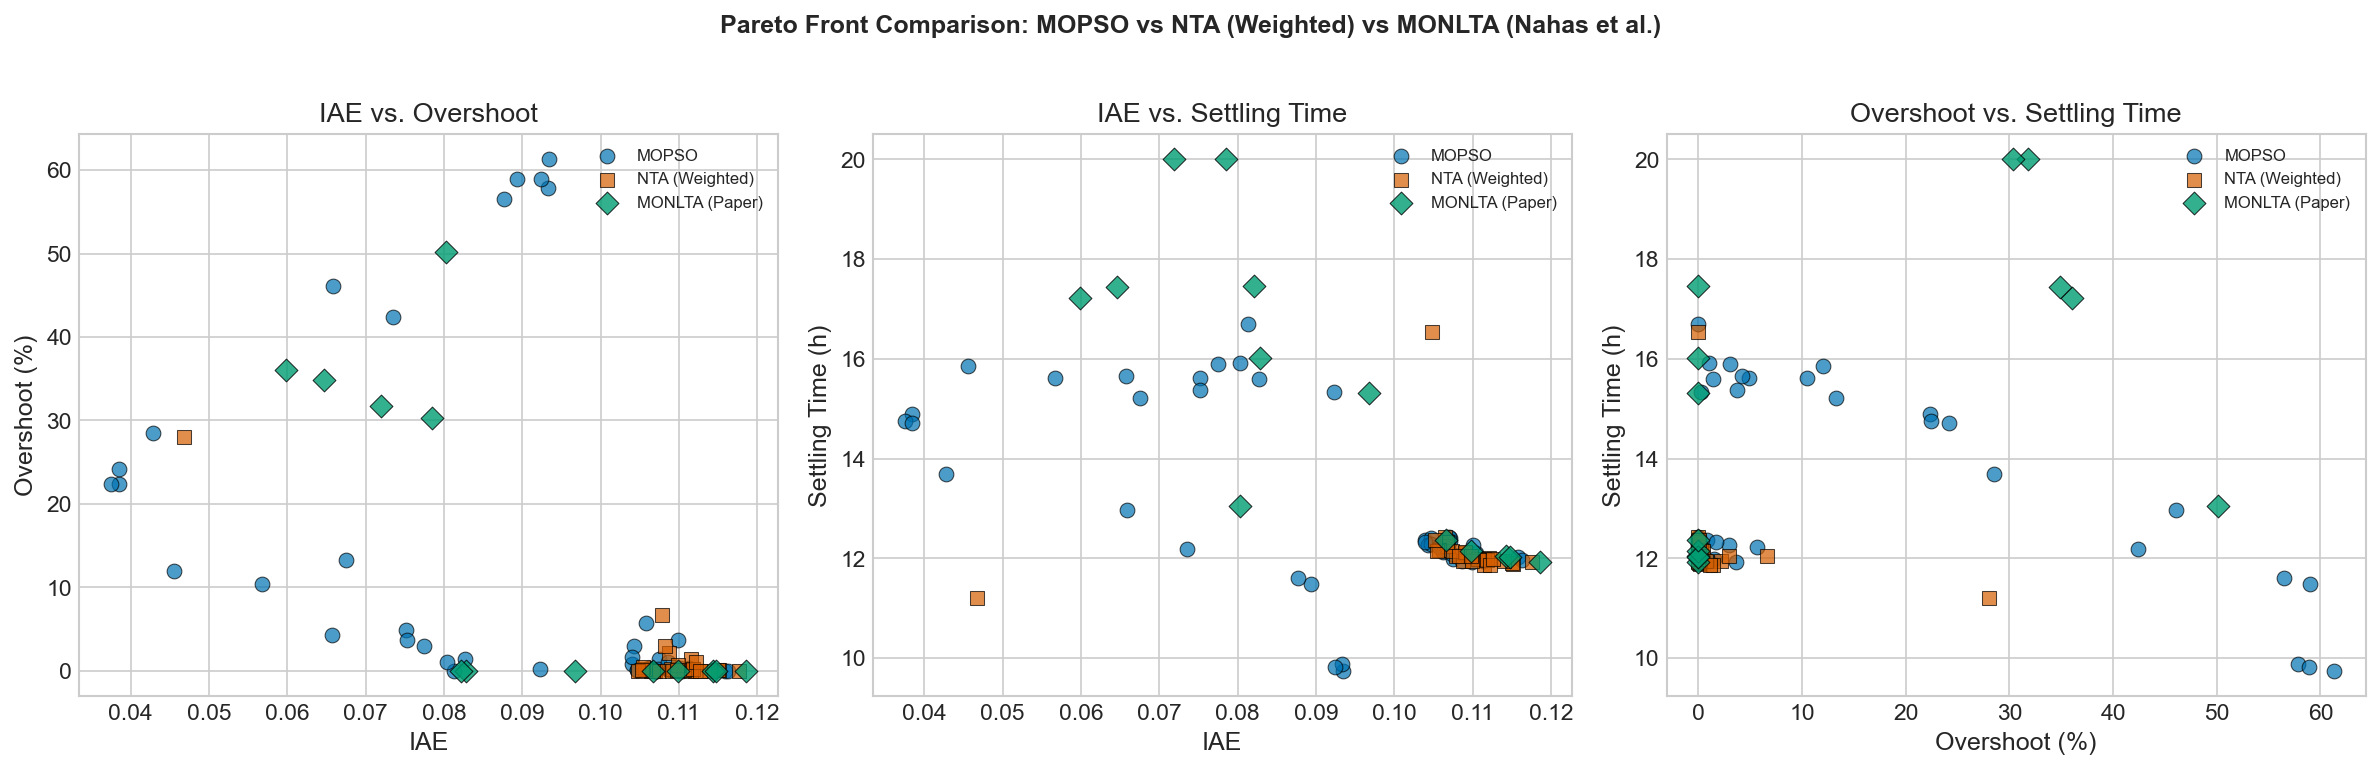

✅ 3-method Pareto front comparison saved


In [15]:
# ============================================================
# VISUALIZE PARETO FRONTS — 3-METHOD 2D PROJECTIONS
# ============================================================
# Three subplots show every pairwise combination of the three
# objectives.  Each method uses a distinct marker shape for
# colorblind-friendly differentiation:
#   MOPSO   → circle (o),   NTA → square (s),   MONLTA → diamond (D)
# ============================================================

fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

# ---------- Extract objective vectors for each method ----------
mopso_iae = [obj[0] for obj in mopso_objectives]
mopso_os  = [obj[1] for obj in mopso_objectives]
mopso_ts  = [obj[2] for obj in mopso_objectives]

nta_iae = [obj[0] for obj in nta_objectives]
nta_os  = [obj[1] for obj in nta_objectives]
nta_ts  = [obj[2] for obj in nta_objectives]

monlta_iae = [obj[0] for obj in monlta_objectives]
monlta_os  = [obj[1] for obj in monlta_objectives]
monlta_ts  = [obj[2] for obj in monlta_objectives]

# ---------- Panel 1: IAE vs Overshoot ----------
ax1.scatter(mopso_iae, mopso_os, c=COLORS['blue'], s=50, alpha=0.7, 
            label='MOPSO', edgecolors='black', linewidth=0.5, marker='o')
ax1.scatter(nta_iae, nta_os, c=COLORS['orange'], s=50, alpha=0.7, 
            label='NTA (Weighted)', edgecolors='black', linewidth=0.5, marker='s')
ax1.scatter(monlta_iae, monlta_os, c=COLORS['green'], s=60, alpha=0.8, 
            label='MONLTA (Paper)', edgecolors='black', linewidth=0.5, marker='D')
ax1.set_xlabel('IAE')
ax1.set_ylabel('Overshoot (%)')
ax1.set_title('IAE vs. Overshoot')
ax1.legend(fontsize=8)

# ---------- Panel 2: IAE vs Settling Time ----------
ax2.scatter(mopso_iae, mopso_ts, c=COLORS['blue'], s=50, alpha=0.7, 
            label='MOPSO', edgecolors='black', linewidth=0.5, marker='o')
ax2.scatter(nta_iae, nta_ts, c=COLORS['orange'], s=50, alpha=0.7, 
            label='NTA (Weighted)', edgecolors='black', linewidth=0.5, marker='s')
ax2.scatter(monlta_iae, monlta_ts, c=COLORS['green'], s=60, alpha=0.8, 
            label='MONLTA (Paper)', edgecolors='black', linewidth=0.5, marker='D')
ax2.set_xlabel('IAE')
ax2.set_ylabel('Settling Time (h)')
ax2.set_title('IAE vs. Settling Time')
ax2.legend(fontsize=8)

# ---------- Panel 3: Overshoot vs Settling Time ----------
ax3.scatter(mopso_os, mopso_ts, c=COLORS['blue'], s=50, alpha=0.7, 
            label='MOPSO', edgecolors='black', linewidth=0.5, marker='o')
ax3.scatter(nta_os, nta_ts, c=COLORS['orange'], s=50, alpha=0.7, 
            label='NTA (Weighted)', edgecolors='black', linewidth=0.5, marker='s')
ax3.scatter(monlta_os, monlta_ts, c=COLORS['green'], s=60, alpha=0.8, 
            label='MONLTA (Paper)', edgecolors='black', linewidth=0.5, marker='D')
ax3.set_xlabel('Overshoot (%)')
ax3.set_ylabel('Settling Time (h)')
ax3.set_title('Overshoot vs. Settling Time')
ax3.legend(fontsize=8)

plt.suptitle('Pareto Front Comparison: MOPSO vs NTA (Weighted) vs MONLTA (Nahas et al.)', 
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('Figures/pareto_front_comparison_3methods.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 3-method Pareto front comparison saved")

### 6.2 Three-Dimensional Pareto Fronts

The full tri-objective Pareto surface is visualized for each method individually.  Separating the methods into distinct 3D subplots avoids marker overlap and lets us judge the **spread** and **shape** of each archive independently.  Rotate these plots interactively (in a live notebook) to inspect coverage from different angles.

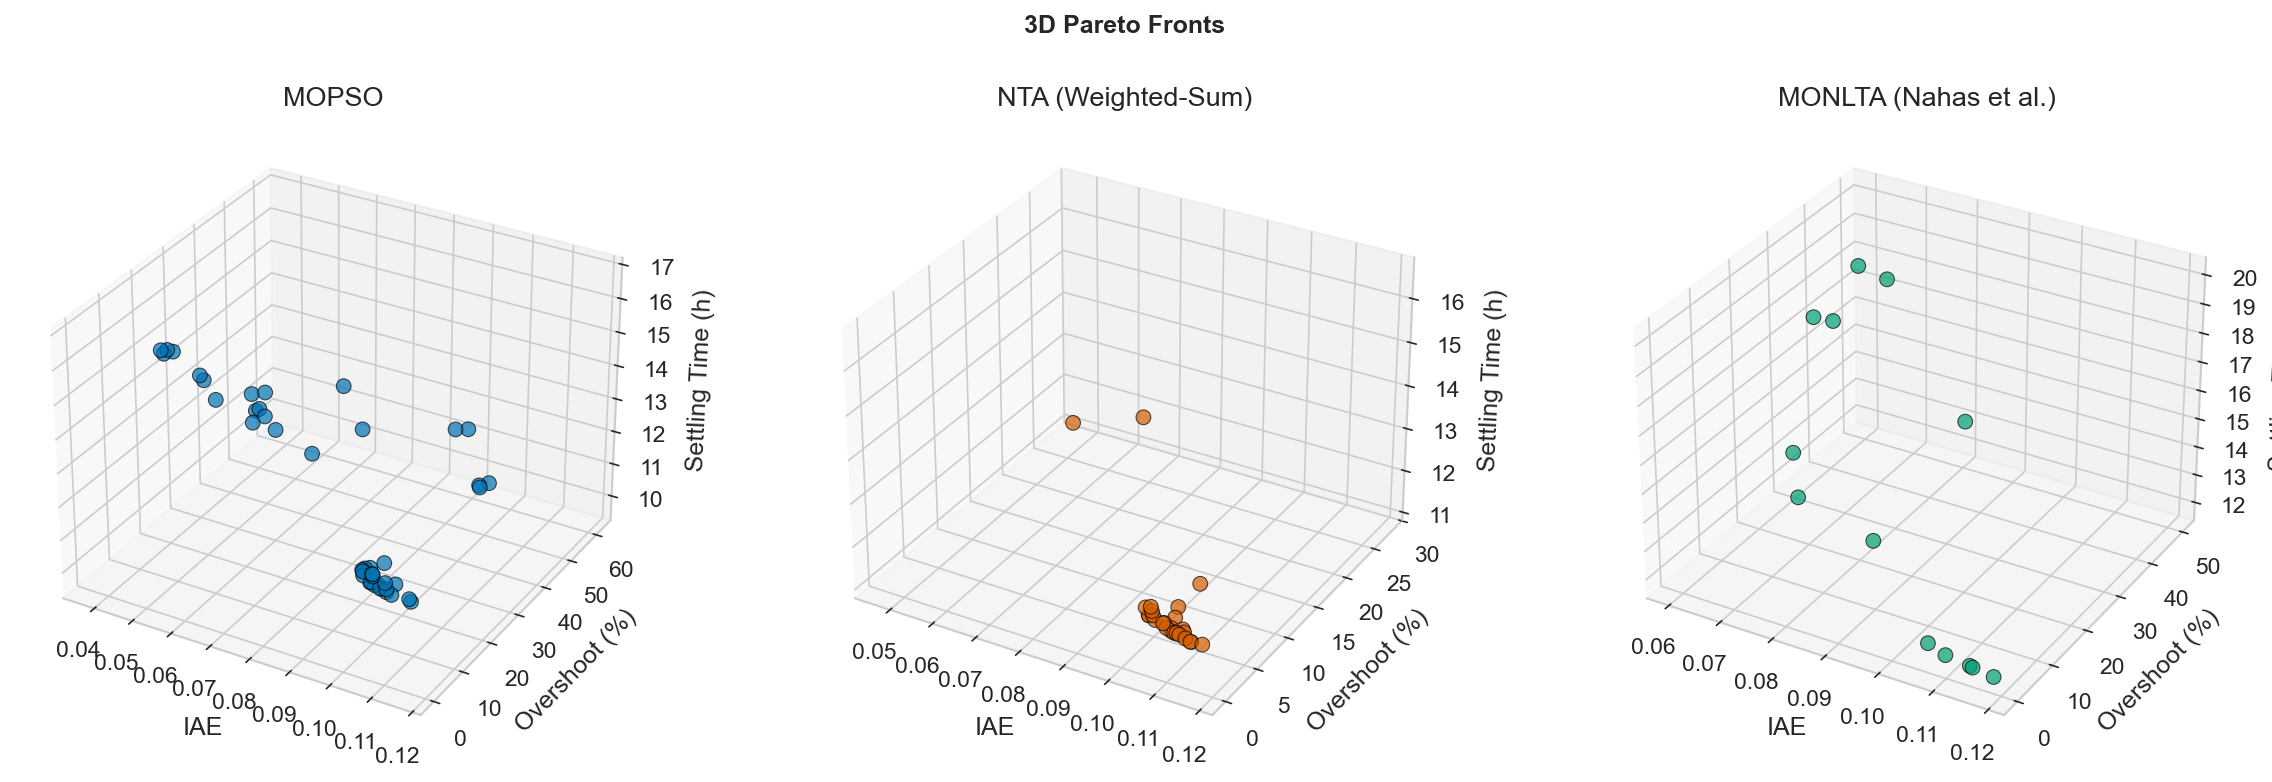

✅ 3D Pareto fronts saved


In [16]:
# ============================================================
# 3D PARETO FRONT VISUALIZATION — ALL THREE METHODS
# ============================================================
# Each method's archive is plotted in its own 3D subplot so
# the shape of the Pareto surface can be examined without
# visual clutter.  The axes are consistent across panels
# for direct comparison.
# ============================================================

from mpl_toolkits.mplot3d import Axes3D  # Required for projection='3d'

fig = plt.figure(figsize=(16, 5))

# ---------- MOPSO 3D ----------
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(mopso_iae, mopso_os, mopso_ts, c=COLORS['blue'], s=50, alpha=0.7, 
            edgecolors='black', linewidth=0.5)
ax1.set_xlabel('IAE')
ax1.set_ylabel('Overshoot (%)')
ax1.set_zlabel('Settling Time (h)')
ax1.set_title('MOPSO')

# ---------- NTA (Weighted) 3D ----------
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(nta_iae, nta_os, nta_ts, c=COLORS['orange'], s=50, alpha=0.7, 
            edgecolors='black', linewidth=0.5)
ax2.set_xlabel('IAE')
ax2.set_ylabel('Overshoot (%)')
ax2.set_zlabel('Settling Time (h)')
ax2.set_title('NTA (Weighted-Sum)')

# ---------- MONLTA 3D ----------
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(monlta_iae, monlta_os, monlta_ts, c=COLORS['green'], s=50, alpha=0.7, 
            edgecolors='black', linewidth=0.5)
ax3.set_xlabel('IAE')
ax3.set_ylabel('Overshoot (%)')
ax3.set_zlabel('Settling Time (h)')
ax3.set_title('MONLTA (Nahas et al.)')

plt.suptitle('3D Pareto Fronts', fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('Figures/pareto_front_3d_3methods.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 3D Pareto fronts saved")

### 6.3 Decision-Making: Selecting a Compromise Solution

A Pareto front contains many equally "optimal" solutions — the engineer must choose one.  We apply two systematic decision-making procedures:

| Method | How it works |
|:---|:---|
| **Euclidean Distance to Ideal** | Normalize each objective to $[0, 1]$, then pick the solution closest to the origin (the utopia point where every objective is minimized simultaneously). Simple but assumes equal importance of all objectives. |
| **TOPSIS** | *Technique for Order of Preference by Similarity to Ideal Solution* — finds the solution that is simultaneously closest to the Positive Ideal Solution (PIS) and farthest from the Negative Ideal Solution (NIS).  More robust when objectives have different scales. |

Both methods use equal weights $w_i = 1/3$ here; in practice, domain experts can adjust these to express preference (e.g., weighting overshoot more heavily for safety-critical glass melter operation).

In [17]:
# ============================================================
# DECISION-MAKING: SELECT BEST COMPROMISE SOLUTIONS
# ============================================================
# Given a Pareto front, we need a single "best" PID gain set.
# Two strategies are implemented:
#   1. Euclidean distance to the utopia point (0,0,0) after
#      min-max normalization.
#   2. TOPSIS — ranks solutions by relative closeness to the
#      Positive Ideal Solution (PIS).
# ============================================================

def select_best_compromise(solutions, objectives, method='euclidean'):
    """
    Select the best compromise solution from a Pareto front.
    
    Parameters
    ----------
    solutions : list of arrays
        Decision variable vectors [Kp, Ki, Kd] for each Pareto member.
    objectives : list of arrays
        Objective vectors [IAE, Overshoot, Settling] for each member.
    method : str
        'euclidean' — minimize ‖f_norm‖₂ to the origin.
        'topsis'   — maximize relative closeness C* = d⁻/(d⁺ + d⁻).
    
    Returns
    -------
    best_sol : array — PID gains of the selected solution.
    best_obj : array — Objective values of the selected solution.
    best_idx : int   — Index into the Pareto front.
    """
    if len(objectives) == 0:
        return None, None, -1
    
    obj_array = np.array(objectives)
    n, m = obj_array.shape
    
    # --- Step 1: Min-max normalization to [0, 1] ---
    # This ensures all objectives contribute equally regardless of scale
    obj_min = obj_array.min(axis=0)
    obj_max = obj_array.max(axis=0)
    obj_range = obj_max - obj_min
    obj_range[obj_range == 0] = 1       # Avoid division by zero
    obj_norm = (obj_array - obj_min) / obj_range
    
    if method == 'euclidean':
        # --- Euclidean: distance to utopia point (0, 0, 0) ---
        distances = np.sqrt(np.sum(obj_norm**2, axis=1))
        best_idx = np.argmin(distances)
    
    elif method == 'topsis':
        # --- TOPSIS (Hwang & Yoon, 1981) ---
        # Step 2: Apply equal weights (all objectives equally important)
        weights = np.ones(m) / m
        weighted = obj_norm * weights
        
        # Step 3: Identify ideal and anti-ideal solutions
        PIS = weighted.min(axis=0)  # Positive Ideal: best value per objective
        NIS = weighted.max(axis=0)  # Negative Ideal: worst value per objective
        
        # Step 4: Euclidean distance from each solution to PIS and NIS
        d_pos = np.sqrt(np.sum((weighted - PIS)**2, axis=1))  # Distance to best
        d_neg = np.sqrt(np.sum((weighted - NIS)**2, axis=1))  # Distance to worst
        
        # Step 5: Relative closeness C* ∈ [0, 1]; higher is better
        closeness = d_neg / (d_pos + d_neg + 1e-12)
        best_idx = np.argmax(closeness)
    
    return solutions[best_idx], objectives[best_idx], best_idx


# ============================================================
# Apply BOTH decision methods to all three optimizers
# ============================================================

print("="*75)
print("BEST COMPROMISE SOLUTIONS — Euclidean Distance to Ideal")
print("="*75)

mopso_best_sol, mopso_best_obj, _ = select_best_compromise(mopso_solutions, mopso_objectives, 'euclidean')
nta_best_sol, nta_best_obj, _ = select_best_compromise(nta_solutions, nta_objectives, 'euclidean')
monlta_best_sol, monlta_best_obj, _ = select_best_compromise(monlta_solutions, monlta_objectives, 'euclidean')

for name, sol, obj in [("MOPSO", mopso_best_sol, mopso_best_obj), 
                        ("NTA (Weighted)", nta_best_sol, nta_best_obj),
                        ("MONLTA (Paper)", monlta_best_sol, monlta_best_obj)]:
    print(f"\n{name}:")
    print(f"  Kp = {sol[0]:.4f}, Ki = {sol[1]:.4f}, Kd = {sol[2]:.4f}")
    print(f"  IAE = {obj[0]:.4f}, Overshoot = {obj[1]:.2f}%, Settling = {obj[2]:.2f} h")

# --- TOPSIS selection (used for time-domain plots in Section 6.4) ---
print("\n" + "="*75)
print("BEST COMPROMISE SOLUTIONS — TOPSIS (Equal Weights)")
print("="*75)

mopso_topsis_sol, mopso_topsis_obj, _ = select_best_compromise(mopso_solutions, mopso_objectives, 'topsis')
nta_topsis_sol, nta_topsis_obj, _ = select_best_compromise(nta_solutions, nta_objectives, 'topsis')
monlta_topsis_sol, monlta_topsis_obj, _ = select_best_compromise(monlta_solutions, monlta_objectives, 'topsis')

for name, sol, obj in [("MOPSO", mopso_topsis_sol, mopso_topsis_obj), 
                        ("NTA (Weighted)", nta_topsis_sol, nta_topsis_obj),
                        ("MONLTA (Paper)", monlta_topsis_sol, monlta_topsis_obj)]:
    print(f"\n{name}:")
    print(f"  Kp = {sol[0]:.4f}, Ki = {sol[1]:.4f}, Kd = {sol[2]:.4f}")
    print(f"  IAE = {obj[0]:.4f}, Overshoot = {obj[1]:.2f}%, Settling = {obj[2]:.2f} h")

BEST COMPROMISE SOLUTIONS — Euclidean Distance to Ideal

MOPSO:
  Kp = 500.0000, Ki = 80.7568, Kd = 6.1003
  IAE = 0.0428, Overshoot = 28.53%, Settling = 13.69 h

NTA (Weighted):
  Kp = 116.1871, Ki = 100.0000, Kd = 39.5624
  IAE = 0.1054, Overshoot = 0.40%, Settling = 12.15 h

MONLTA (Paper):
  Kp = 320.8075, Ki = 85.4271, Kd = 7.3550
  IAE = 0.0829, Overshoot = 0.00%, Settling = 16.01 h

BEST COMPROMISE SOLUTIONS — TOPSIS (Equal Weights)

MOPSO:
  Kp = 500.0000, Ki = 80.7568, Kd = 6.1003
  IAE = 0.0428, Overshoot = 28.53%, Settling = 13.69 h

NTA (Weighted):
  Kp = 116.1871, Ki = 100.0000, Kd = 39.5624
  IAE = 0.1054, Overshoot = 0.40%, Settling = 12.15 h

MONLTA (Paper):
  Kp = 320.8075, Ki = 85.4271, Kd = 7.3550
  IAE = 0.0829, Overshoot = 0.00%, Settling = 16.01 h


### 6.4 Closed-Loop Controller Comparison

Using the **TOPSIS-selected** PID gains from each method, we simulate the full closed-loop response (setpoint tracking + disturbance rejection) and compare against a hand-tuned **baseline PID** ($K_p=50$, $K_i=5$, $K_d=2$).

The upper subplot shows the **glass level response** $h(t)$, while the lower subplot shows the **control effort** $u(t)$ (feed rate in t/h).  An effective controller should:
- Reach the setpoint quickly (low rise time),
- Exhibit minimal overshoot (safe operation),
- Reject the disturbance at $t = 10$ h promptly (fast settling),
- Use smooth, bounded control effort (actuator feasibility).

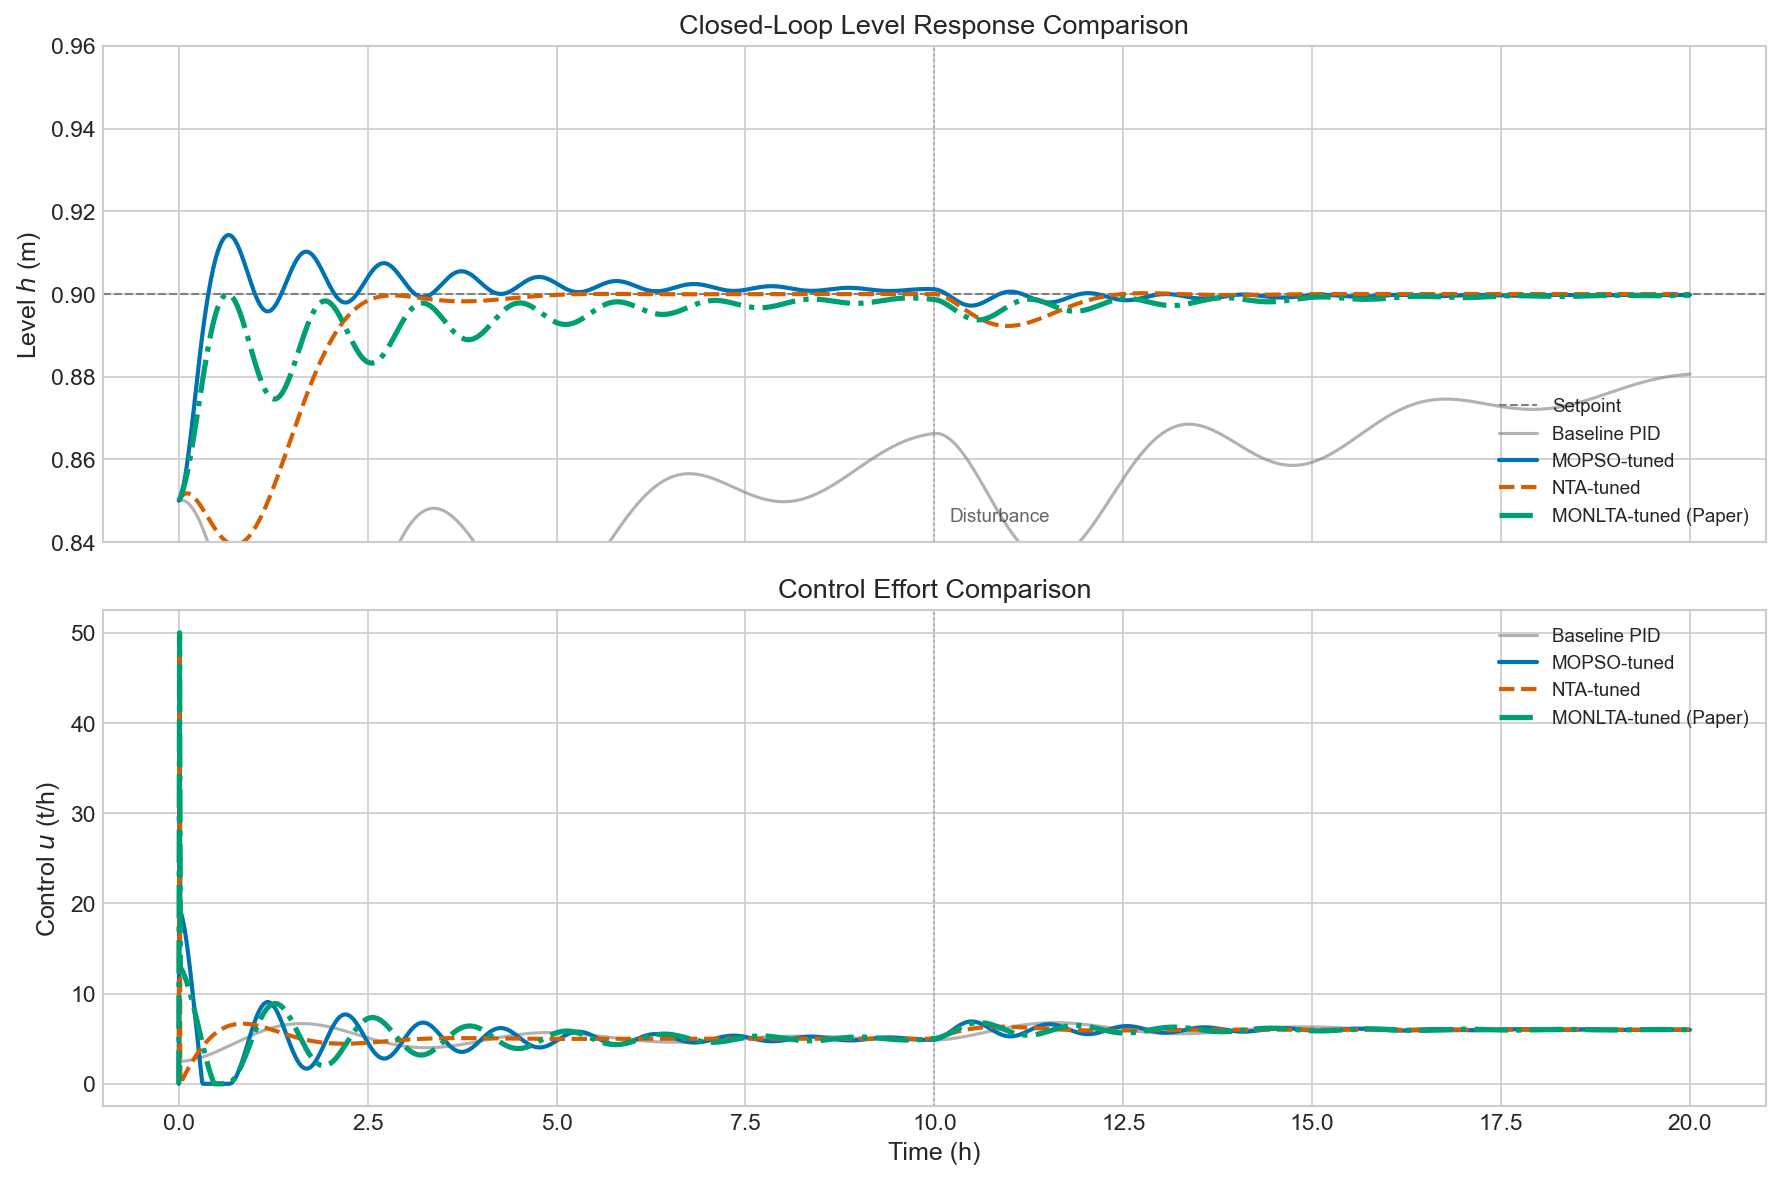

✅ Controller comparison saved


In [18]:
# ============================================================
# SIMULATE AND COMPARE BEST CONTROLLERS — 3 METHODS + BASELINE
# ============================================================
# Each optimized PID (TOPSIS-selected) and a hand-tuned baseline
# are simulated over the full 20 h horizon (setpoint at t=0,
# disturbance at t=10 h).  Two subplots: level h(t) and control u(t).
# ============================================================

# --- Simulate TOPSIS-selected PID gains for each method ---
t_mopso, h_mopso, u_mopso, m_mopso = simulate_closed_loop(
    mopso_topsis_sol[0], mopso_topsis_sol[1], mopso_topsis_sol[2], params
)
t_nta, h_nta, u_nta, m_nta = simulate_closed_loop(
    nta_topsis_sol[0], nta_topsis_sol[1], nta_topsis_sol[2], params
)
t_monlta, h_monlta, u_monlta, m_monlta = simulate_closed_loop(
    monlta_topsis_sol[0], monlta_topsis_sol[1], monlta_topsis_sol[2], params
)

# --- Baseline: conservative hand-tuned PID for reference ---
t_base, h_base, u_base, metrics_base = simulate_closed_loop(
    Kp=50, Ki=5, Kd=2, params=params
)

# ---- Plot: Level Response (top) + Control Effort (bottom) ----
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# -- Upper panel: glass level h(t) --
ax1 = axes[0]
ax1.axhline(y=0.9, color='gray', linestyle='--', linewidth=1, label='Setpoint')
ax1.axvline(x=10, color='gray', linestyle=':', linewidth=1, alpha=0.5)  # Disturbance onset
ax1.plot(t_base, h_base, color='gray', linewidth=1.5, alpha=0.6, label='Baseline PID')
ax1.plot(t_mopso, h_mopso, color=COLORS['blue'], linewidth=2, label='MOPSO-tuned')
ax1.plot(t_nta, h_nta, color=COLORS['orange'], linewidth=2, linestyle='--', label='NTA-tuned')
ax1.plot(t_monlta, h_monlta, color=COLORS['green'], linewidth=2.5, linestyle='-.', label='MONLTA-tuned (Paper)')
ax1.set_ylabel('Level $h$ (m)')
ax1.legend(loc='lower right', fontsize=9)
ax1.set_ylim([0.84, 0.96])
ax1.text(10.2, 0.845, 'Disturbance', fontsize=9, alpha=0.7)
ax1.set_title('Closed-Loop Level Response Comparison')

# -- Lower panel: control effort u(t) --
ax2 = axes[1]
ax2.axvline(x=10, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax2.plot(t_base, u_base, color='gray', linewidth=1.5, alpha=0.6, label='Baseline PID')
ax2.plot(t_mopso, u_mopso, color=COLORS['blue'], linewidth=2, label='MOPSO-tuned')
ax2.plot(t_nta, u_nta, color=COLORS['orange'], linewidth=2, linestyle='--', label='NTA-tuned')
ax2.plot(t_monlta, u_monlta, color=COLORS['green'], linewidth=2.5, linestyle='-.', label='MONLTA-tuned (Paper)')
ax2.set_xlabel('Time (h)')
ax2.set_ylabel('Control $u$ (t/h)')
ax2.legend(loc='upper right', fontsize=9)
ax2.set_title('Control Effort Comparison')

plt.tight_layout()
plt.savefig('Figures/controller_comparison_3methods.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Controller comparison saved")

### 6.5 Comprehensive Performance Summary

The table below compiles **all performance metrics** for the TOPSIS-selected controllers and the hand-tuned baseline.  Metrics follow the paper's evaluation framework:

| Metric | Symbol | Lower is Better? |
|:---|:---|:---:|
| Integral Absolute Error | IAE | Yes |
| Integral Squared Error | ISE | Yes |
| Integral Time-weighted Squared Error | ITSE | Yes |
| Overshoot | OS (%) | Yes |
| 2% Settling Time | $T_s$ (h) | Yes |
| Rise Time (10%→90%) | $T_r$ (h) | Yes |
| Peak Time | $T_p$ (h) | Yes |

Additionally, **Pareto front statistics** and a **dominance analysis** quantify how many MONLTA archive members dominate the best solutions found by the other two methods.

In [19]:
# ============================================================
# COMPREHENSIVE PERFORMANCE SUMMARY TABLE
# ============================================================
# Prints the PID gains and all seven performance metrics for
# each method's TOPSIS-selected solution plus the hand-tuned
# baseline.  Also reports Pareto front sizes and dominance
# counts (how many MONLTA solutions dominate the other methods'
# best compromise solution).
# ============================================================

print("="*110)
print("COMPREHENSIVE PERFORMANCE COMPARISON (TOPSIS-selected solutions)")
print("="*110)

# Column headers: Gains │ Error integrals │ Transient metrics
header = (f"{'Method':<22} {'Kp':>8} {'Ki':>8} {'Kd':>8} │ {'IAE':>8} {'ISE':>8} {'ITSE':>8} "
          f"│ {'OS(%)':>8} {'Ts(h)':>8} {'Tr(h)':>8} {'Tp(h)':>8}")
print(header)
print("-"*110)

results = [
    ("Baseline PID", 50, 5, 2, metrics_base),
    ("MOPSO", mopso_topsis_sol[0], mopso_topsis_sol[1], mopso_topsis_sol[2], m_mopso),
    ("NTA (Weighted)", nta_topsis_sol[0], nta_topsis_sol[1], nta_topsis_sol[2], m_nta),
    ("MONLTA (Paper)", monlta_topsis_sol[0], monlta_topsis_sol[1], monlta_topsis_sol[2], m_monlta),
]

for name, kp, ki, kd, m in results:
    print(f"{name:<22} {kp:>8.2f} {ki:>8.2f} {kd:>8.2f} │ "
          f"{m['IAE']:>8.4f} {m['ISE']:>8.5f} {m['ITSE']:>8.5f} │ "
          f"{m['overshoot']:>8.2f} {m['settling_time']:>8.2f} {m['rise_time']:>8.4f} {m['peak_time']:>8.4f}")

print("="*110)

# --- Pareto front statistics ---
# Larger archives suggest better coverage of the trade-off surface
print("\nPareto Front Statistics:")
print(f"  MOPSO:          {len(mopso_solutions):3d} non-dominated solutions")
print(f"  NTA (Weighted): {len(nta_solutions):3d} non-dominated solutions")
print(f"  MONLTA (Paper): {len(monlta_solutions):3d} non-dominated solutions")

# --- Dominance analysis ---
# Count how many MONLTA archive members dominate each rival's TOPSIS-best
monlta_dominates_mopso = sum(1 for obj in monlta_objectives 
                              if dominates(obj, list(mopso_topsis_obj)))
monlta_dominates_nta = sum(1 for obj in monlta_objectives 
                            if dominates(obj, list(nta_topsis_obj)))

print(f"\nDominance Analysis:")
print(f"  MONLTA solutions dominating MOPSO-best: {monlta_dominates_mopso}/{len(monlta_solutions)}")
print(f"  MONLTA solutions dominating NTA-best:   {monlta_dominates_nta}/{len(monlta_solutions)}")

COMPREHENSIVE PERFORMANCE COMPARISON (TOPSIS-selected solutions)
Method                       Kp       Ki       Kd │      IAE      ISE     ITSE │    OS(%)    Ts(h)    Tr(h)    Tp(h)
--------------------------------------------------------------------------------------------------------------
Baseline PID              50.00     5.00     2.00 │   0.9944  0.06002  0.35322 │     0.00    20.00  13.5568  20.0000
MOPSO                    500.00    80.76     6.10 │   0.0428  0.00055  0.00043 │    28.53    13.69   0.2701   0.6603
NTA (Weighted)           116.19   100.00    39.56 │   0.1054  0.00454  0.00413 │     0.40    12.15   0.9705  12.7864
MONLTA (Paper)           320.81    85.43     7.35 │   0.0829  0.00114  0.00198 │     0.00    16.01   0.3902   0.6503

Pareto Front Statistics:
  MOPSO:           44 non-dominated solutions
  NTA (Weighted):  27 non-dominated solutions
  MONLTA (Paper):  13 non-dominated solutions

Dominance Analysis:
  MONLTA solutions dominating MOPSO-best: 0/13
  MONLT

### 6.6 Convergence Analysis

Convergence plots reveal **how quickly** each optimizer builds its Pareto archive and improves solution quality:

- **MOPSO** (left): Archive size and best IAE vs. iteration.  A plateau indicates the swarm has converged.
- **NTA Weighted-Sum** (center): Archive size after each weight-vector run.  Growth should be monotonic since each subproblem can only add new non-dominated solutions.
- **MONLTA** (right): Archive size (bars) and acceptance rate (line) per episode.  A declining accept rate shows the search tightening as $\zeta \to 0$ reduces the acceptance threshold $H(\zeta)$.

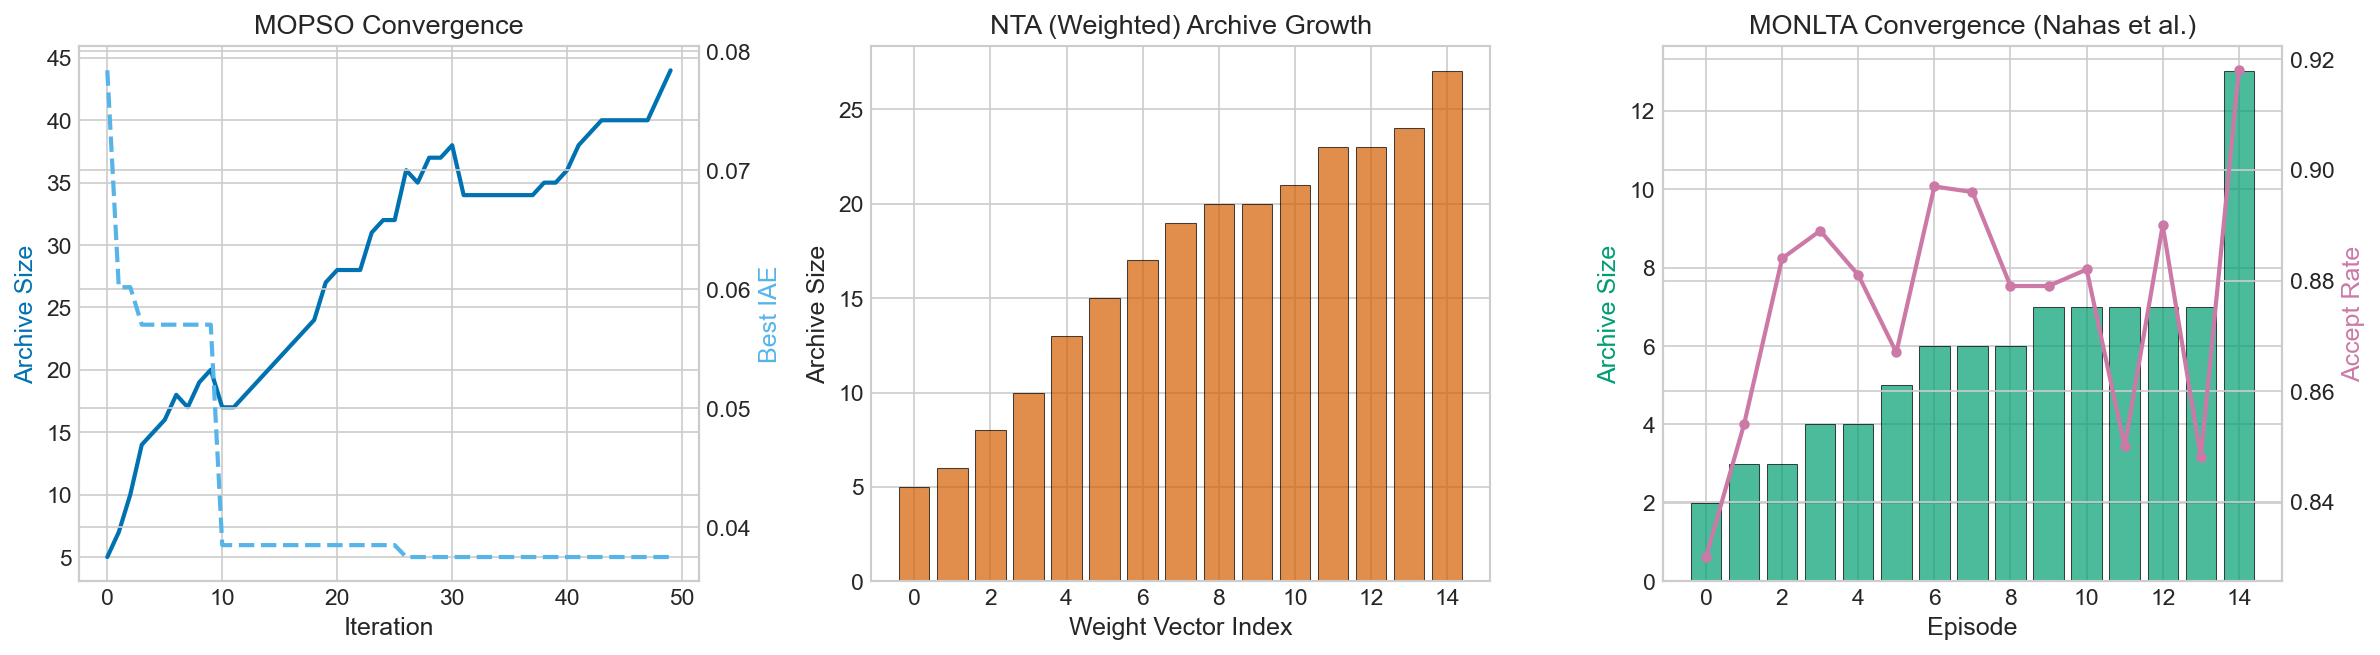

✅ Convergence analysis saved


In [20]:
# ============================================================
# CONVERGENCE ANALYSIS — ALL THREE METHODS
# ============================================================
# Each optimizer logs its history during optimization.  We
# extract and visualize key convergence indicators:
#   MOPSO  → archive size & best IAE over iterations
#   NTA    → archive size after each weight-vector subproblem
#   MONLTA → archive size & accept rate per episode
# Dual y-axes (twinx) overlay two quantities per panel.
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# ---------- Panel 1: MOPSO convergence ----------
ax1 = axes[0]
iterations = [h['iteration'] for h in mopso.history]
archive_sizes = [h['archive_size'] for h in mopso.history]
best_iae = [h['best_IAE'] for h in mopso.history]

ax1_twin = ax1.twinx()  # Second y-axis for IAE
ax1.plot(iterations, archive_sizes, color=COLORS['blue'], linewidth=2, label='Archive Size')
ax1_twin.plot(iterations, best_iae, color=COLORS['cyan'], linewidth=2, linestyle='--', label='Best IAE')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Archive Size', color=COLORS['blue'])
ax1_twin.set_ylabel('Best IAE', color=COLORS['cyan'])
ax1.set_title('MOPSO Convergence')

# ---------- Panel 2: NTA (Weighted) archive growth ----------
ax2 = axes[1]
weight_idx = [h['weight_idx'] for h in nta.history]
archive_sizes_nta = [h['archive_size'] for h in nta.history]

ax2.bar(weight_idx, archive_sizes_nta, color=COLORS['orange'], alpha=0.7, 
        edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Weight Vector Index')
ax2.set_ylabel('Archive Size')
ax2.set_title('NTA (Weighted) Archive Growth')

# ---------- Panel 3: MONLTA episode statistics ----------
ax3 = axes[2]
episodes = [h['episode'] for h in monlta.episode_history]
archive_sizes_monlta = [h['archive_size'] for h in monlta.episode_history]
accept_rates = [h['accept_rate'] for h in monlta.episode_history]

ax3_twin = ax3.twinx()  # Second y-axis for accept rate
ax3.bar(episodes, archive_sizes_monlta, color=COLORS['green'], alpha=0.7, 
        edgecolor='black', linewidth=0.5, label='Archive Size')
ax3_twin.plot(episodes, accept_rates, color=COLORS['purple'], linewidth=2, 
              marker='o', markersize=4, label='Accept Rate')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Archive Size', color=COLORS['green'])
ax3_twin.set_ylabel('Accept Rate', color=COLORS['purple'])
ax3.set_title('MONLTA Convergence (Nahas et al.)')

plt.tight_layout()
plt.savefig('Figures/convergence_analysis_3methods.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Convergence analysis saved")

### 6.7 MONLTA Deep Dive: Accepting Function & Episode Analysis

This section visualizes two key aspects unique to the MONLTA algorithm:

**Left panel — Nonlinear Accepting Function $H(\zeta)$:**
$$H(\zeta) = \frac{1}{\sqrt{1 + \left(\frac{\zeta}{\zeta_0}\right)^2}}$$

This low-pass filter curve controls the acceptance threshold.  At low $\zeta$ (early iterations), $H(\zeta) \approx 1$ — nearly all moves are accepted (exploration).  As $\zeta$ increases toward $\zeta_{\text{start}} = 40$, $H$ drops toward zero — only improving moves survive (exploitation).  The transition bandwidth is governed by $\zeta_0 = 1/0.0075 \approx 133.3$.

**Right panel — Per-Episode Statistics:**
Bar chart of acceptance rates (%) overlaid with archive growth across episodes.  Expect declining accept rates as the archive fills with high-quality solutions and the algorithm becomes more selective.

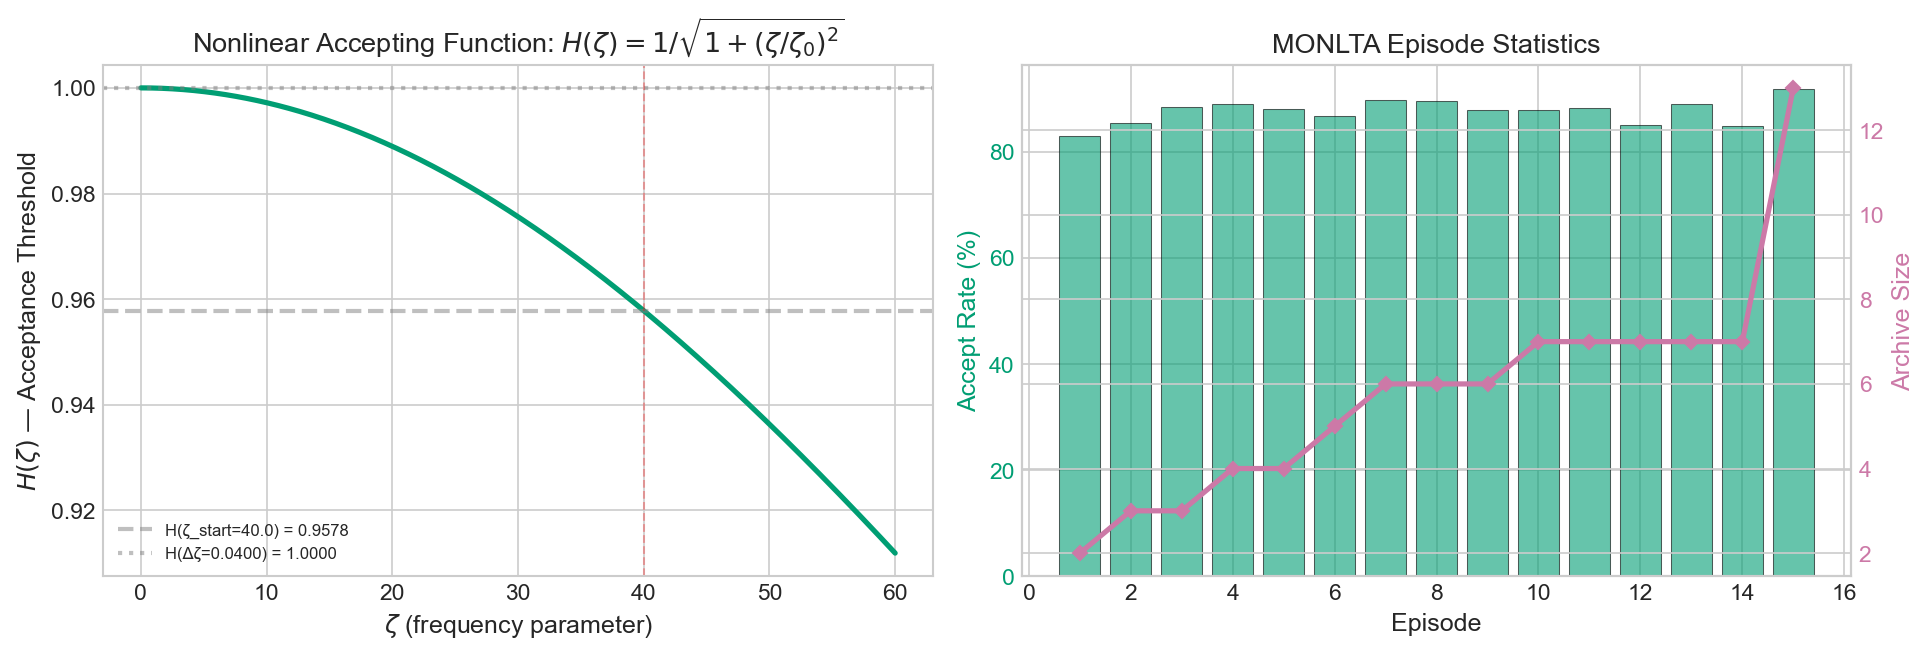

✅ MONLTA analysis plots saved


In [21]:
# ============================================================
# MONLTA: NONLINEAR ACCEPTING FUNCTION VISUALIZATION
# & EPISODE STATISTICS
# ============================================================
# Left:  Plot H(ζ) over a range of ζ values with annotations
#         showing the start and end thresholds used during search.
# Right: Per-episode accept rate (bars) and archive size (line)
#         to illustrate convergence behavior.
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# ---------- Left panel: H(ζ) accepting function ----------
ax1 = axes[0]
zeta_range = np.linspace(0.01, 60, 500)               # ζ range for plotting
H_values = 1.0 / np.sqrt(1.0 + (zeta_range / monlta.zeta_0) ** 2)  # Eq. from paper

# Plot the smooth curve
ax1.plot(zeta_range, H_values, color=COLORS['green'], linewidth=2.5)

# Annotate the start and end threshold levels
ax1.axhline(y=monlta.H(monlta.zeta_start), color='gray', linestyle='--', alpha=0.5, 
            label=f'H(ζ_start={monlta.zeta_start}) = {monlta.H(monlta.zeta_start):.4f}')
ax1.axhline(y=monlta.H(monlta.delta_zeta), color='gray', linestyle=':', alpha=0.5,
            label=f'H(Δζ={monlta.delta_zeta:.4f}) = {monlta.H(monlta.delta_zeta):.4f}')
ax1.axvline(x=monlta.zeta_start, color='red', linestyle='--', alpha=0.3, linewidth=1)
ax1.set_xlabel(r'$\zeta$ (frequency parameter)')
ax1.set_ylabel(r'$H(\zeta)$ — Acceptance Threshold')
ax1.set_title(r'Nonlinear Accepting Function: $H(\zeta) = 1/\sqrt{1+(\zeta/\zeta_0)^2}$')
ax1.legend(fontsize=8)

# Arrow annotation pointing to the half-power frequency ζ₀
ax1.annotate(f'ζ₀ = {monlta.zeta_0:.1f}', xy=(monlta.zeta_0, 0.707), xytext=(monlta.zeta_0+10, 0.75),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=9)

# ---------- Right panel: per-episode accept rate + archive size ----------
ax2 = axes[1]
episodes = [h['episode'] + 1 for h in monlta.episode_history]   # 1-indexed for display
accept_rates = [h['accept_rate'] * 100 for h in monlta.episode_history]  # Convert to %
archive_sizes = [h['archive_size'] for h in monlta.episode_history]

color1, color2 = COLORS['green'], COLORS['purple']

# Bars: accept rate (left y-axis)
bars = ax2.bar(episodes, accept_rates, color=color1, alpha=0.6, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Accept Rate (%)', color=color1)
ax2.tick_params(axis='y', labelcolor=color1)

# Line: archive size (right y-axis via twinx)
ax2_twin = ax2.twinx()
ax2_twin.plot(episodes, archive_sizes, color=color2, linewidth=2.5, marker='D', markersize=5)
ax2_twin.set_ylabel('Archive Size', color=color2)
ax2_twin.tick_params(axis='y', labelcolor=color2)
ax2.set_title('MONLTA Episode Statistics')

plt.tight_layout()
plt.savefig('Figures/monlta_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ MONLTA analysis plots saved")

## 7. Conclusions

### Summary of Approaches

This notebook implements and compares **three multi-objective optimization methods** for PID controller tuning on a glass melter level control system:

| Method | Type | Multi-Objective Strategy | Key Feature |
|--------|------|--------------------------|-------------|
| **MOPSO** | Population-based | Pareto archive + crowding distance | Swarm intelligence, parallel exploration |
| **NTA (Weighted-Sum)** | Local search | Weighted-sum scalarization | Simple, multiple decomposed subproblems |
| **MONLTA (Paper)** | Local search | True Pareto-based with 4 acceptance scenarios | Amount-of-domination, nonlinear accepting function |

### Key Contributions from Nahas et al. (2021) Applied Here

1. **Nonlinear Accepting Function** $H(\zeta) = 1/\sqrt{1+(\zeta/\zeta_0)^2}$: Replaces the conventional power-law cooling schedule with a low-pass filter form, providing more controlled exploration-to-exploitation transition.

2. **Four Acceptance Scenarios**: Unlike weighted-sum NTA, MONLTA uses dominance-based acceptance with an amount-of-domination principle, allowing the algorithm to accept "slightly dominated" solutions for better exploration.

3. **Variable-Size Archive**: Non-dominated solutions are stored and updated using dominance rules, eliminating the need for arbitrary weight assignments.

4. **Focused Perturbation**: Randomly selecting one decision variable at a time (paper's one-gain strategy) provides more targeted search compared to perturbing all variables simultaneously.

5. **Extended Performance Metrics**: ISE, ITSE, ITAE, overshoot, settling time, rise time, and peak time are all computed (following the paper's comprehensive evaluation approach).

6. **TOPSIS Decision-Making**: Added Technique for Order of Preference by Similarity to Ideal Solution for systematic selection from the Pareto front.

### Applications to Glass Melter Control
- **PID controller tuning** for glass level regulation with disturbance rejection
- **Neural ODE hyperparameter optimization** using the same multi-objective framework
- **MPC weight selection** via Pareto-optimal trade-offs
- **Observer gain tuning** with competing objectives (convergence speed vs noise sensitivity)
- **Simultaneous multi-zone tuning** (analogous to the paper's simultaneous AVR-LFC across areas)

### References
- Nahas, Abouheaf, Darghouth, Sharaf, "A multi-objective AVR-LFC optimization scheme for multi-area power systems," *Electric Power Systems Research*, 200, 107467 (2021).
- Coello et al., "Handling Multiple Objectives with Particle Swarm Optimization," *IEEE TEVC*, 2004.